In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map
import hiivemdptoolbox.hiive.mdptoolbox as mdp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gym
import time
import sys
import seaborn as sns

In [3]:
actions = ['L', 'D', 'R', 'U']
random_map = generate_random_map(size=10, p=.95)

P, R = mdp.example.openai('FrozenLake-v1', render=False, desc=random_map, is_slippery=True)
env = gym.make('FrozenLake-v1', desc=random_map, render_mode='', is_slippery=True)

C:\Users\legen\anaconda3\envs\ml\lib\site-packages\gym\envs\registration.py:623: UserWarning: WARN: The environment is being initialised with mode () that is not in the possible render_modes (['human', 'ansi', 'rgb_array']).
  logger.warn(


In [4]:
def run_simulation(policy, env):
    env.reset()
    new_state=0
    for i in range(1000):
        action = policy[new_state]
        new_state, reward, done, other, info = env.step(action)
        if done and reward == 1:
            return i
        if done and reward == 0:
            return 2000
    return 1000

In [5]:
def callback(s, a, s_new):
    return True

In [6]:
def visualize_policy(policy, size, desc):
    ar = np.reshape([actions[x] for x in policy], (size, size))
    arrows = {"R":(1,0), "L":(-1,0),"U":(0,1),"D":(0,-1)}
    scale = .25
    for r, row in enumerate(ar):
        for c, cell in enumerate(row):
            color = 'black'
            if desc[r][c] == 'S':
                color = 'blue'
            elif desc[r][c] == 'G':
                color = 'green'
            elif desc[r][c] == 'H':
                color = 'red'
            plt.arrow(
                c, 
                5 - r, 
                scale*arrows[cell][0], 
                scale*arrows[cell][1], 
                head_width=.3, 
                color=color
            )
    plt.show()

## Epsilon Experiments 

In [21]:
epsilons = [1, .8, .7, .5, .4, .1, .01, .001, .0001]
alphas = [1, .8, .7, .5, .4, .1, .01, .001, .0001]

plot_df = pd.DataFrame(index=range(200000))
error_df = pd.DataFrame(index=range(200000))
reward_df = pd.DataFrame(index=range(200000))
iterations_df = pd.DataFrame(index=range(200000))

policies = []

print(epsilons)
print(alphas)

max_reward = 0
max_a = 0
max_e = 0

rewards = np.ndarray((len(epsilons), len(alphas)))
errors = np.ndarray((len(epsilons), len(alphas)))
mean_values = np.ndarray((len(epsilons), len(alphas)))
times = np.ndarray((len(epsilons), len(alphas)))
number_iterations = np.ndarray((len(epsilons), len(alphas)))


for e_index, e in enumerate(epsilons):
    for a_index, a in enumerate(alphas):
        
        print("---------------------------------------------------")
        ql = mdp.mdp.QLearning(
            P, 
            R, 
            .95,
            alpha=.9,
            alpha_decay=.99997,
            alpha_min=a,
            epsilon=1.0,
            epsilon_min=e,
            epsilon_decay=.999,
            n_iter=100000,
            run_stat_frequency=1,
            iter_callback=callback
        )
        start = time.time()
        results = ql.run()
        end = time.time() - start
        print("Time:", end)
        policies.append((e, a, ql.policy))
        
        number_iterations[e_index][a_index] = pd.Series([run_simulation(ql.policy, env) for i in range(5)]).mean()
        
        reward = pd.Series([x['Reward'] for x in results]).rolling(10000).mean().iloc[-1]
        
        rewards[e_index][a_index] = reward
        times[e_index][a_index] = end
        errors[e_index][a_index] = pd.Series([x['Error'] for x in results]).rolling(10000).mean().iloc[-1]
        mean_values[e_index][a_index] = pd.Series([x['Mean V'] for x in results]).rolling(10000).mean().iloc[-1]
        if reward > max_reward:
            max_reward = reward
            max_a = a
            max_e = e
        
        print(e, a)
        print("Final Reward:", pd.Series([x['Reward'] for x in results]).rolling(10000).mean().iloc[-1])
        print("Final Mean Value:", pd.Series([x['Mean V'] for x in results]).rolling(10000).mean().iloc[-1])
        print("Final Error:", pd.Series([x['Error'] for x in results]).rolling(10000).mean().iloc[-1])
        print("Average Iterations", number_iterations[e_index][a_index])
        reward_df[str(a) + str(e)] = pd.Series([x['Reward'] for x in results])
        plot_df[str(a) + str(e)] = pd.Series([x['Mean V'] for x in results])
        error_df[str(a) + str(e)] = pd.Series([x['Error'] for x in results])
        
print(max_reward)
print(max_a)
print(max_e)

[1, 0.8, 0.7, 0.5, 0.4, 0.1, 0.01, 0.001, 0.0001]
[1, 0.8, 0.7, 0.5, 0.4, 0.1, 0.01, 0.001, 0.0001]
---------------------------------------------------
Time: 4.8095879554748535
1 1
Final Reward: 0.004433333333333333
Final Mean Value: 3.04122098275427
Final Error: 0.3558012661218032
Average Iterations 2000.0
---------------------------------------------------
Time: 4.620992660522461
1 0.8
Final Reward: 0.005233333333333334
Final Mean Value: 1.628446519705586
Final Error: 0.1695528901542908
Average Iterations 2000.0
---------------------------------------------------
Time: 4.638745069503784
1 0.7
Final Reward: 0.005133333333333333
Final Mean Value: 1.7416141354794334
Final Error: 0.15904144231470832
Average Iterations 1615.4
---------------------------------------------------
Time: 4.615054130554199
1 0.5
Final Reward: 0.004633333333333333
Final Mean Value: 0.818814209719463
Final Error: 0.05801997842417143
Average Iterations 1240.0
---------------------------------------------------
Tim

---------------------------------------------------
Time: 4.590075731277466
0.4 0.5
Final Reward: 0.0044333333333333325
Final Mean Value: 0.27076264922942594
Final Error: 0.023579277859692813
Average Iterations 853.2
---------------------------------------------------
Time: 4.586111783981323
0.4 0.4
Final Reward: 0.0044666666666666665
Final Mean Value: 0.3309768722898843
Final Error: 0.021875660089744398
Average Iterations 1200.0
---------------------------------------------------
Time: 4.590459585189819
0.4 0.1
Final Reward: 0.0059
Final Mean Value: 0.20771761395622962
Final Error: 0.0031334102796514974
Average Iterations 58.6
---------------------------------------------------
Time: 4.613454341888428
0.4 0.01
Final Reward: 0.005833333333333333
Final Mean Value: 0.20957141519445713
Final Error: 0.001672641059872291
Average Iterations 73.0
---------------------------------------------------
Time: 4.603041172027588
0.4 0.001
Final Reward: 0.0054333333333333326
Final Mean Value: 0.204388

Time: 4.530439138412476
0.0001 0.1
Final Reward: 0.007533333333333333
Final Mean Value: 0.08685338206977099
Final Error: 0.0028534637561034764
Average Iterations 1000.0
---------------------------------------------------
Time: 4.544855356216431
0.0001 0.01
Final Reward: 0.007333333333333333
Final Mean Value: 0.0660146683370057
Final Error: 0.0011865945958350645
Average Iterations 1000.0
---------------------------------------------------
Time: 4.514535665512085
0.0001 0.001
Final Reward: 0.0069
Final Mean Value: 0.06770532956607854
Final Error: 0.0010034114233194692
Average Iterations 1000.0
---------------------------------------------------
Time: 4.488681316375732
0.0001 0.0001
Final Reward: 0.0063999999999999994
Final Mean Value: 0.03984441253216747
Final Error: 0.0008484781279342149
Average Iterations 1000.0
0.0077
0.01
0.1


1 1


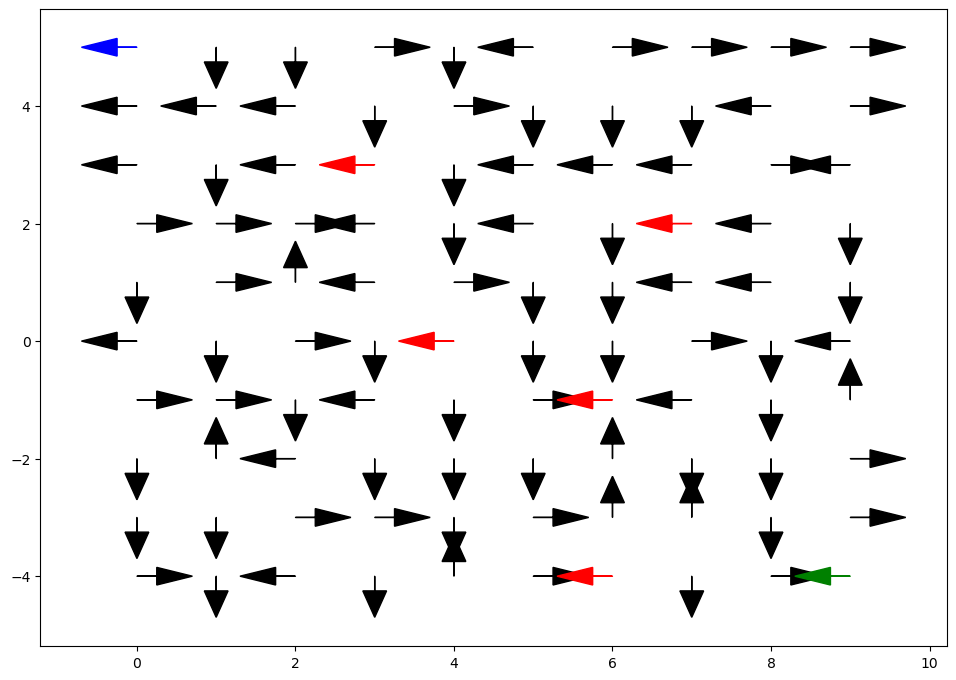

1 0.8


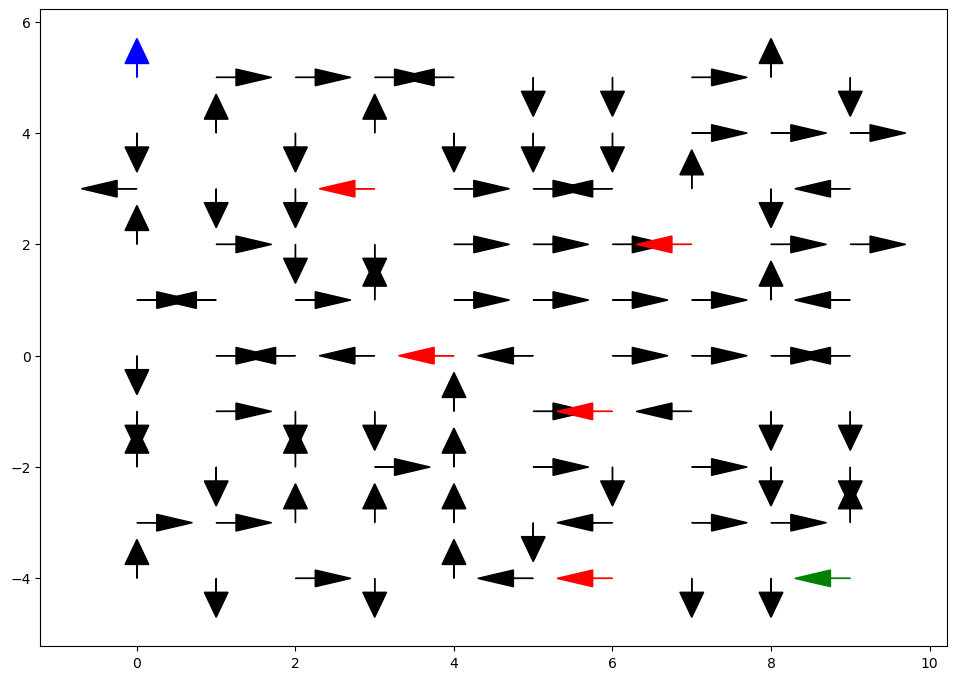

1 0.7


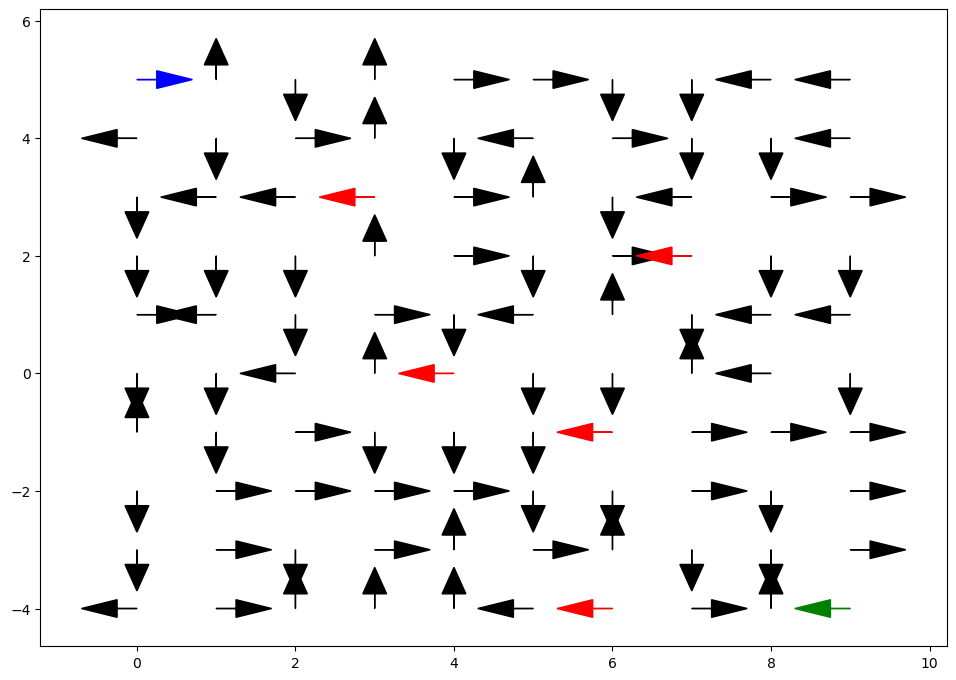

1 0.5


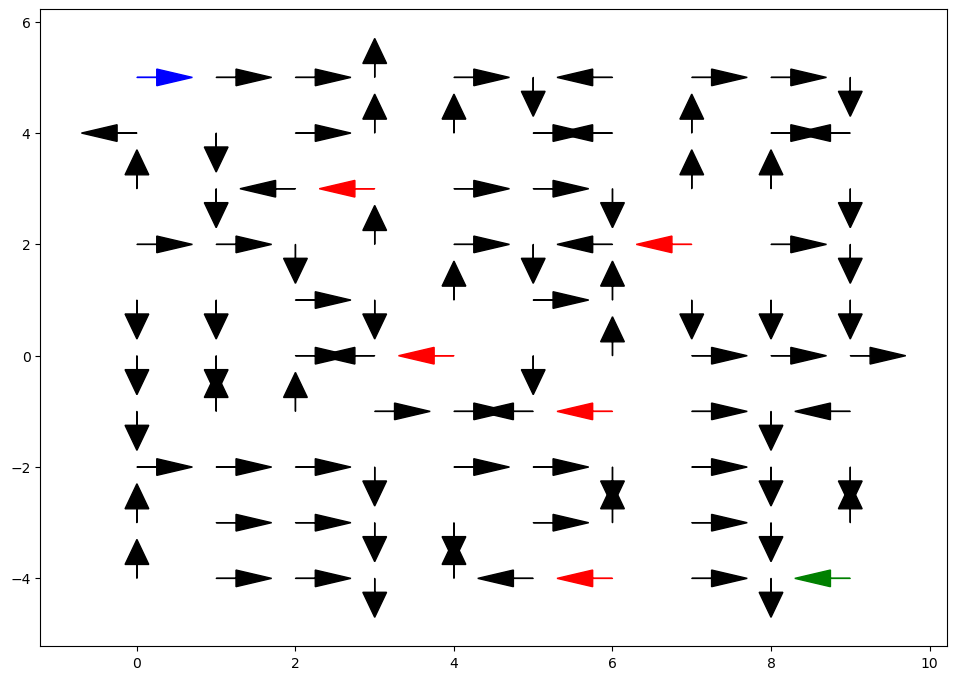

1 0.4


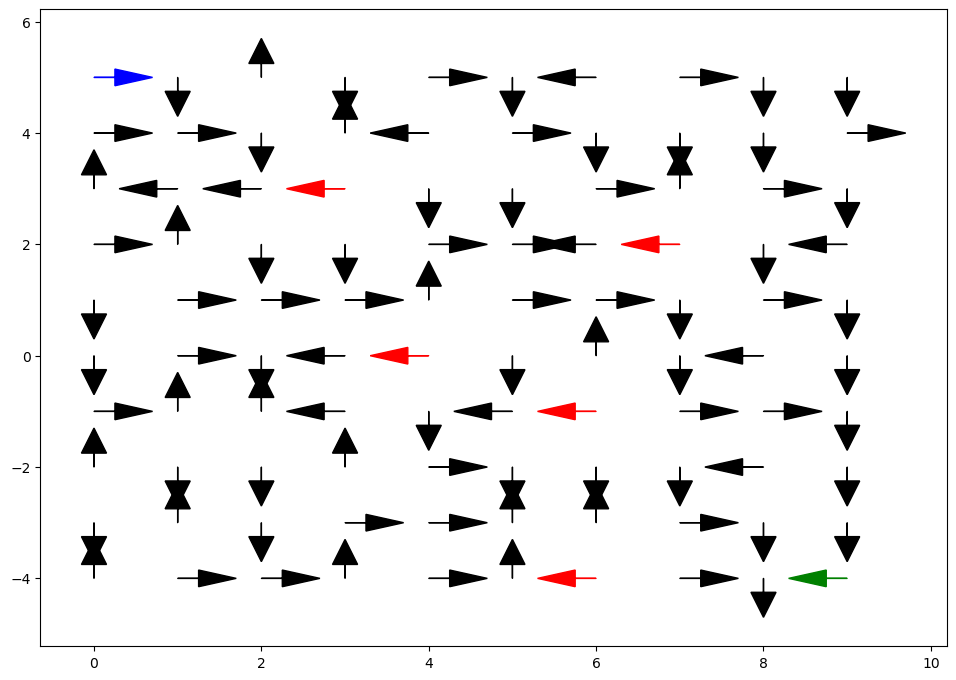

1 0.1


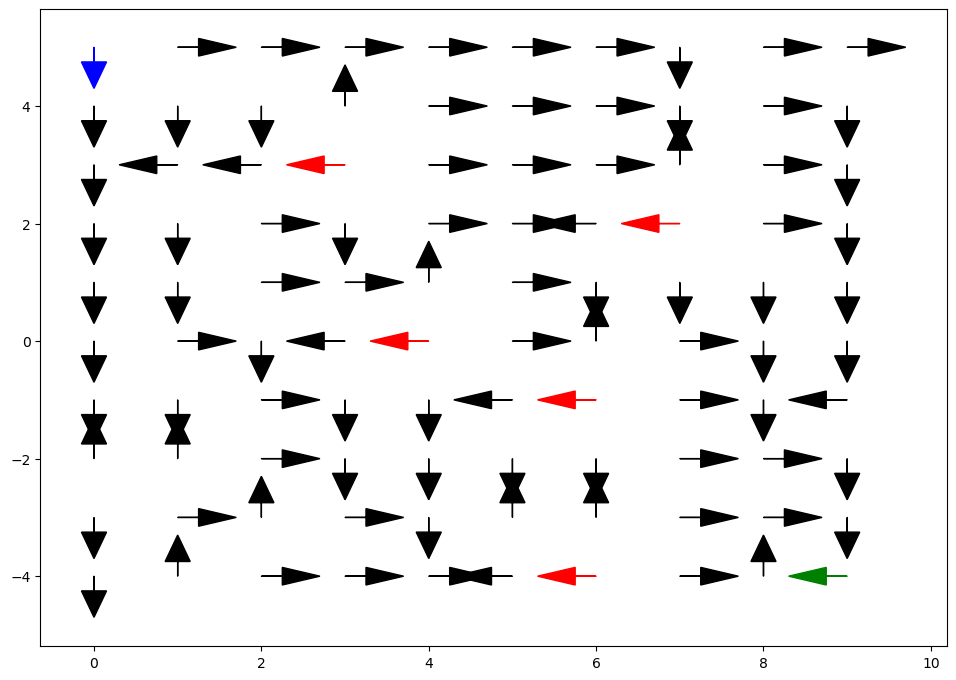

1 0.01


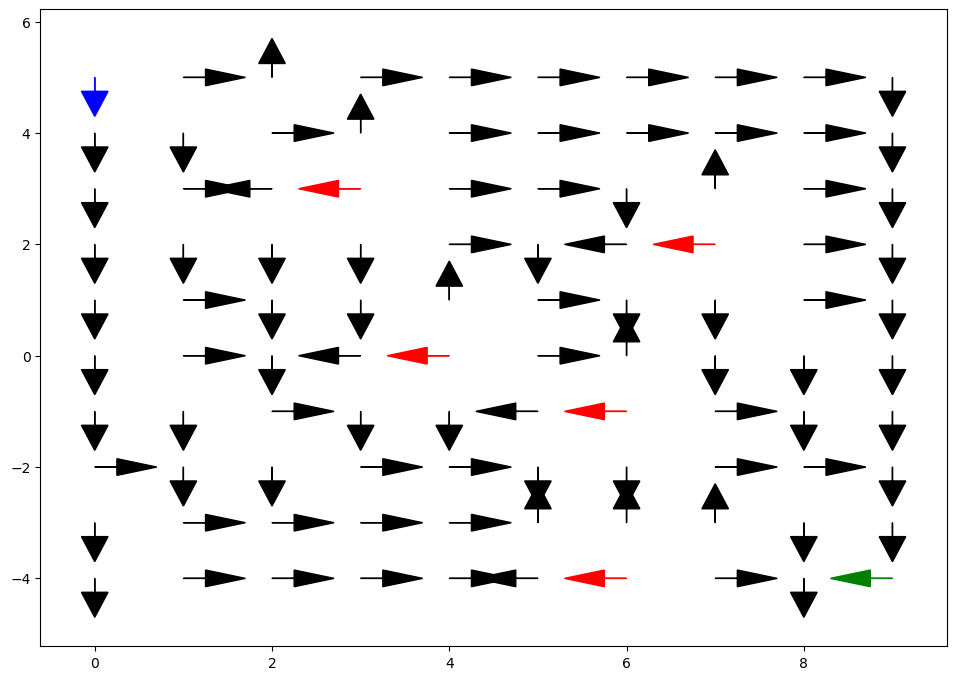

1 0.001


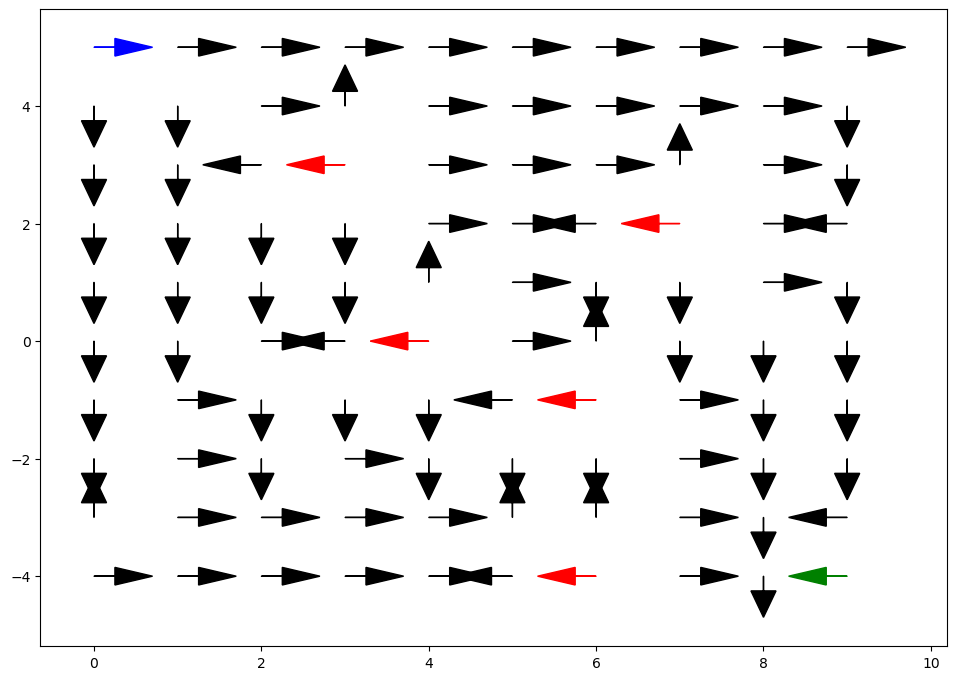

1 0.0001


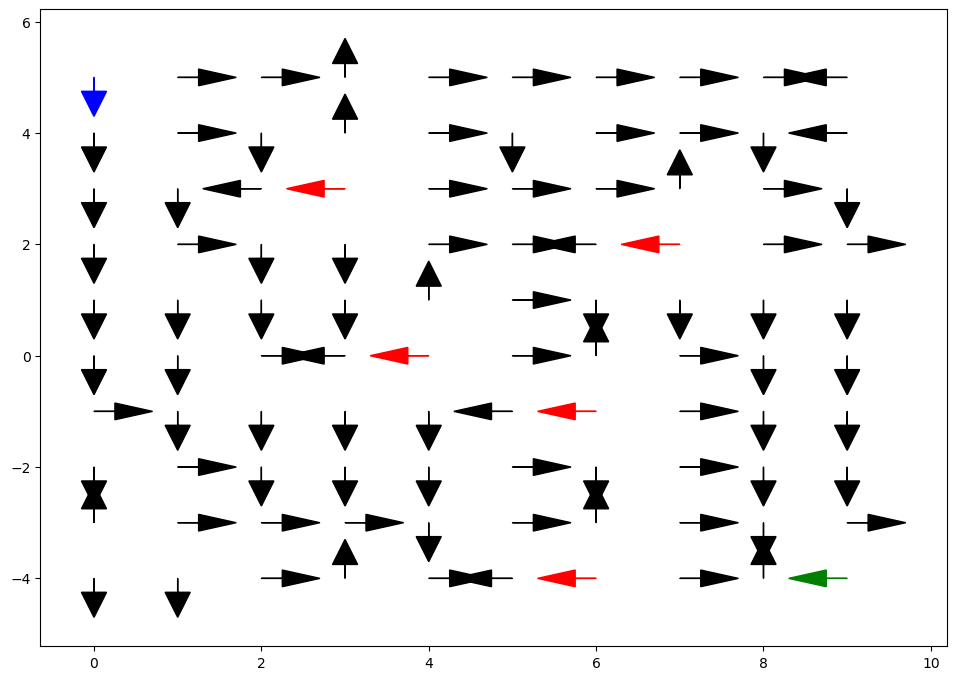

0.8 1


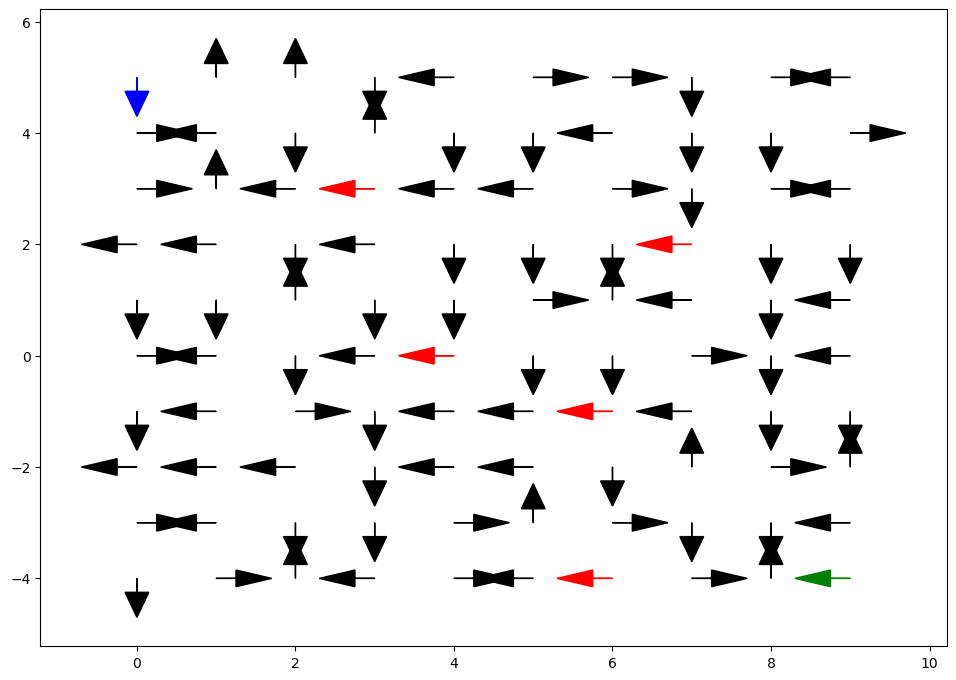

0.8 0.8


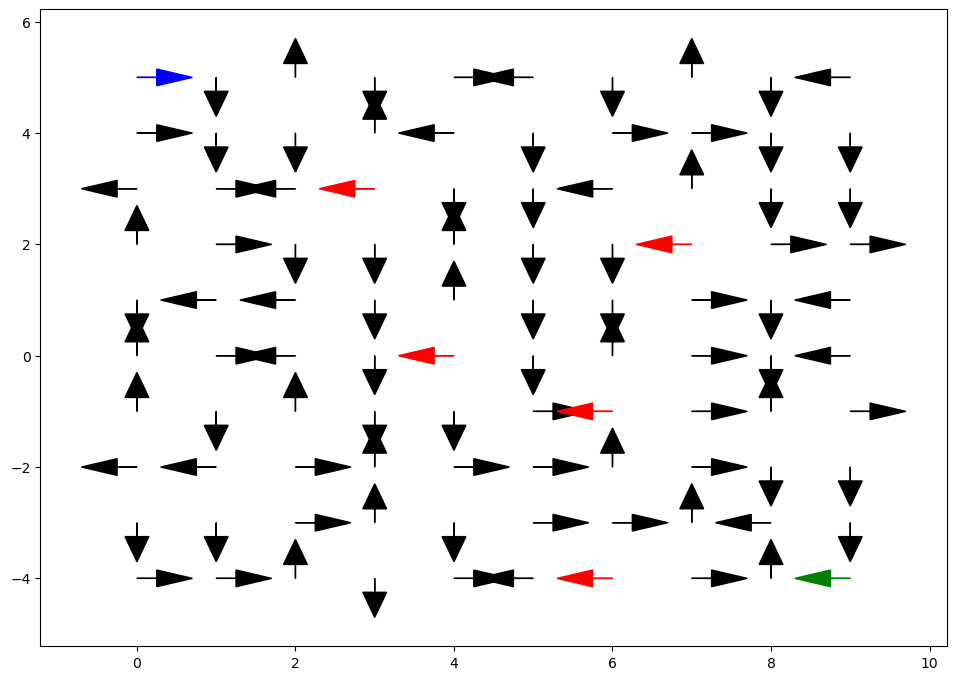

0.8 0.7


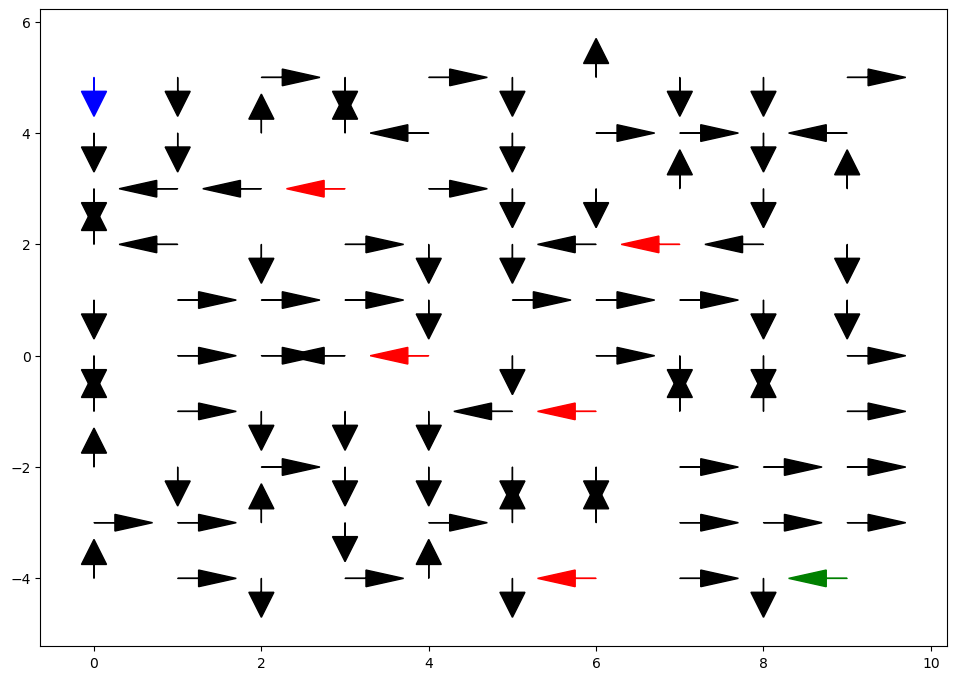

0.8 0.5


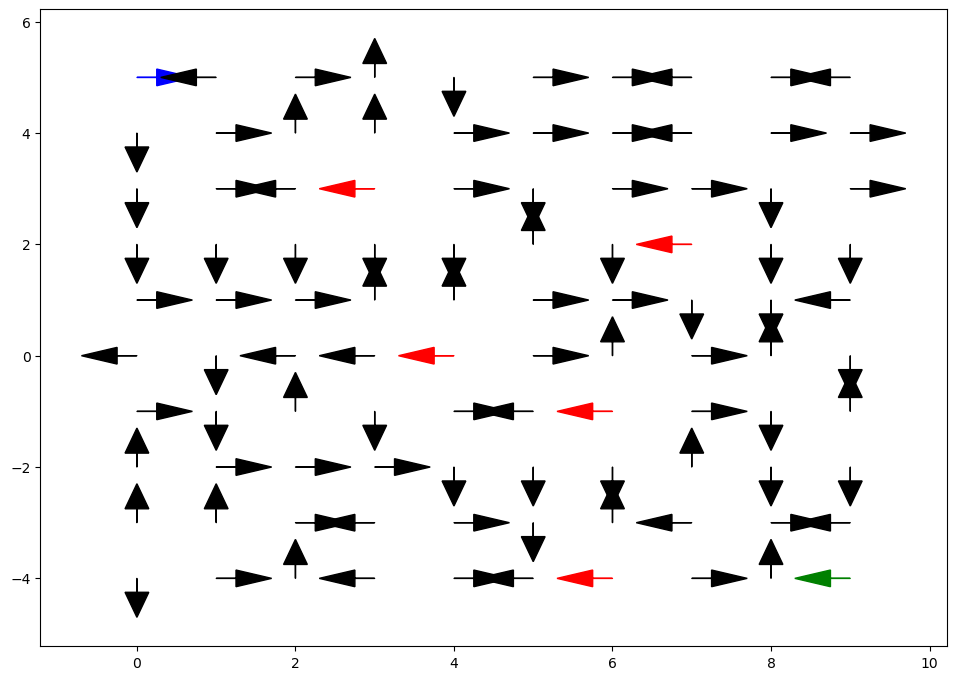

0.8 0.4


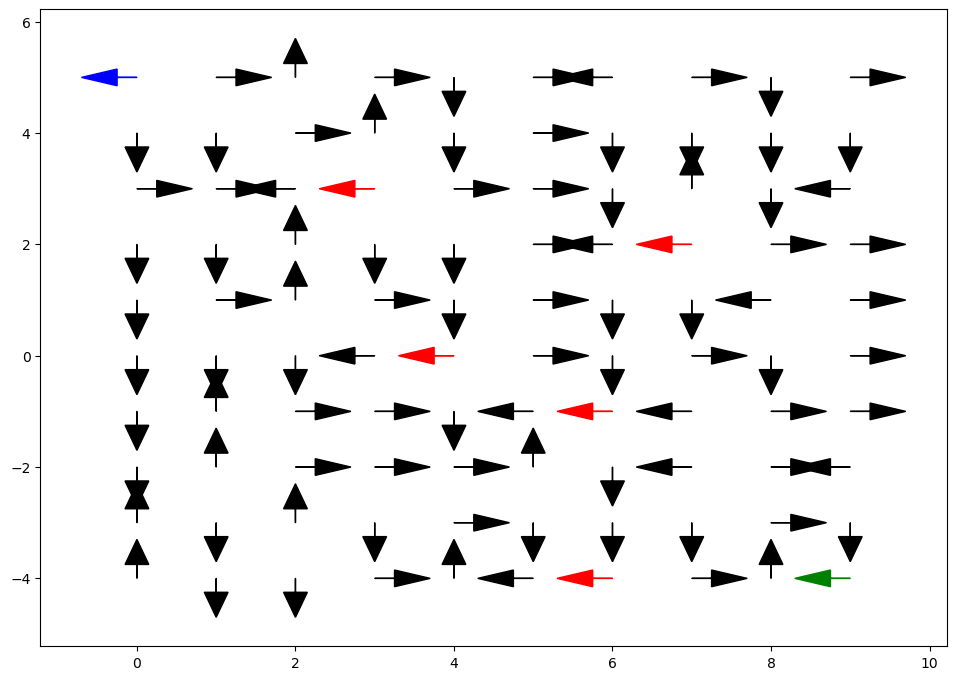

0.8 0.1


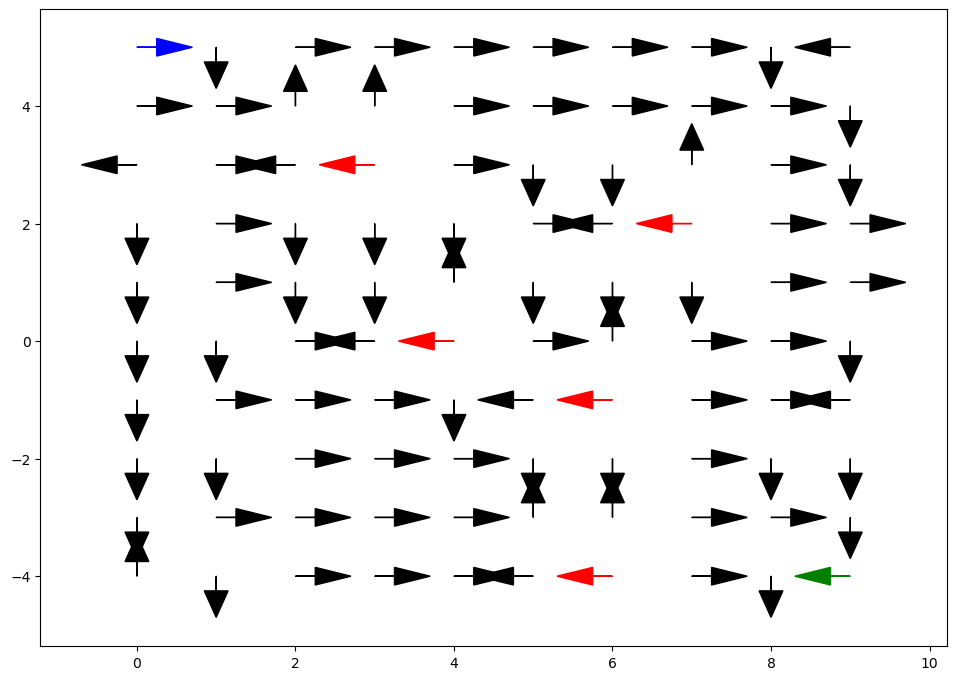

0.8 0.01


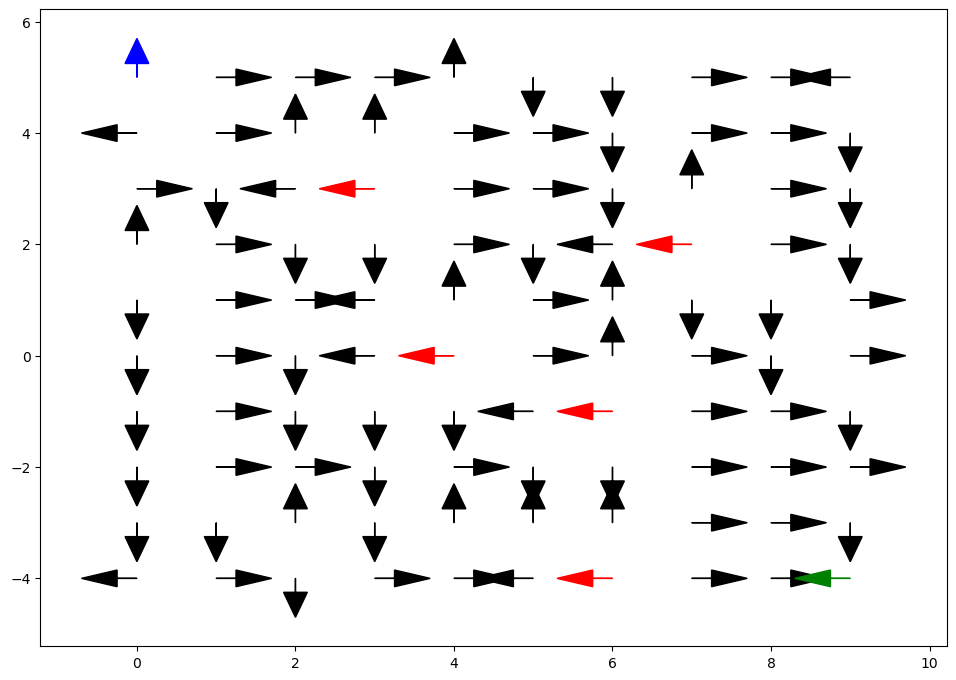

0.8 0.001


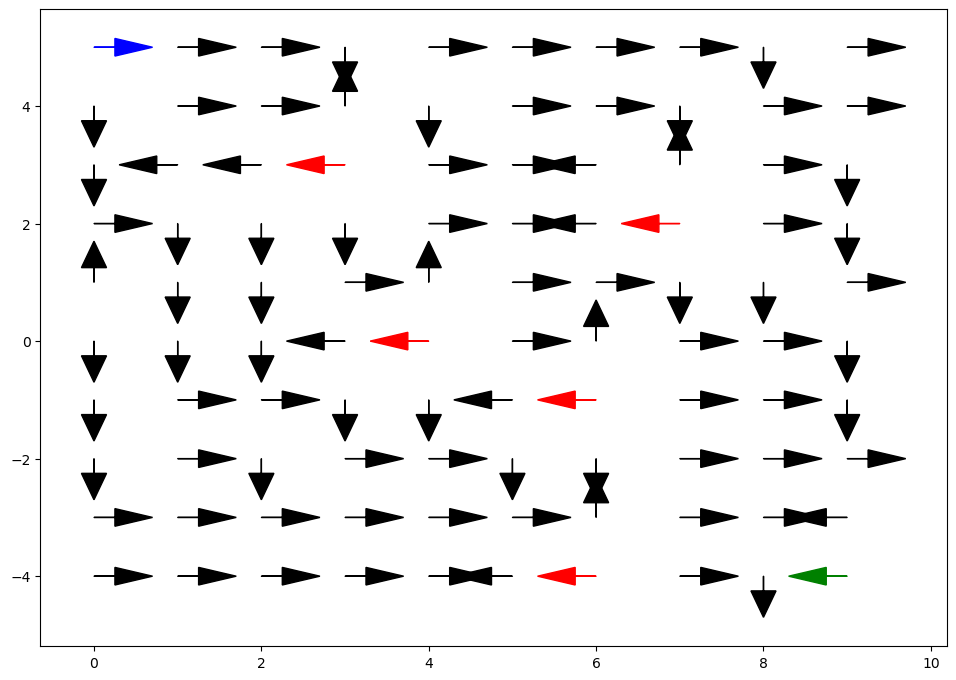

0.8 0.0001


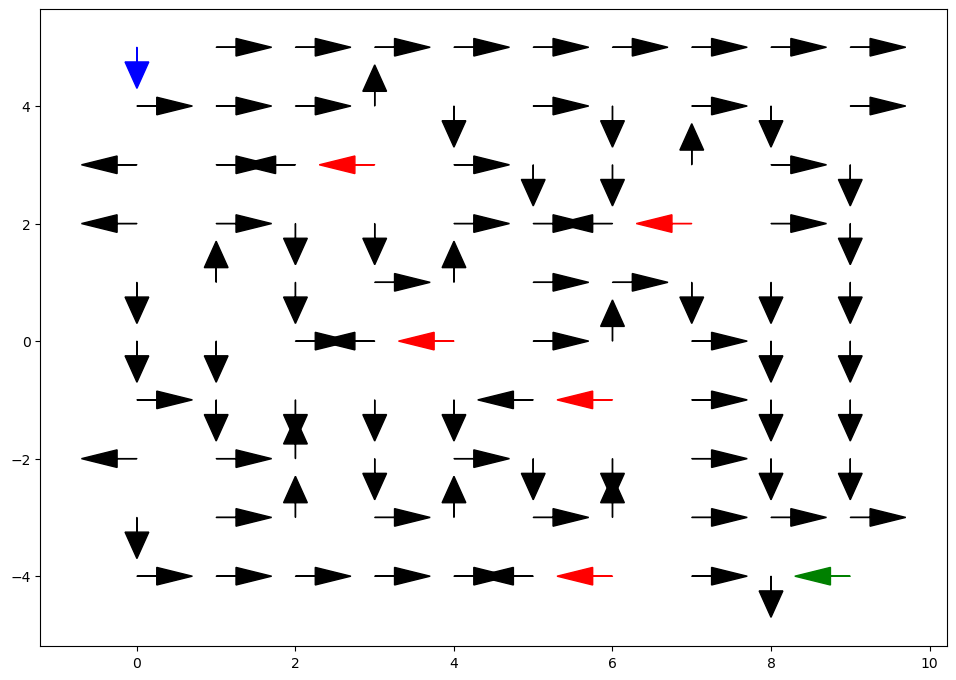

0.7 1


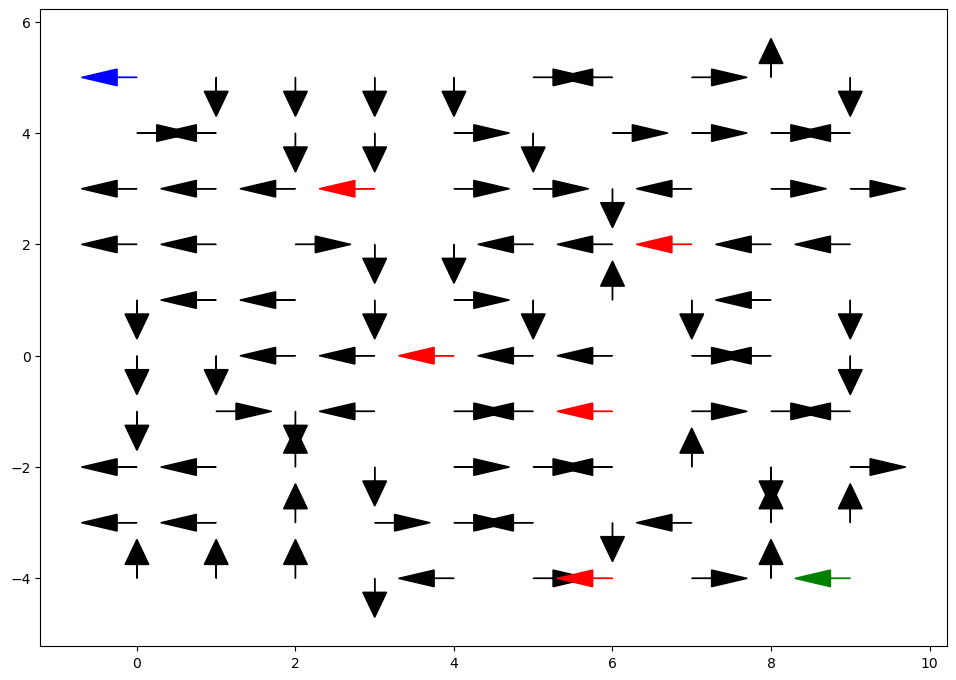

0.7 0.8


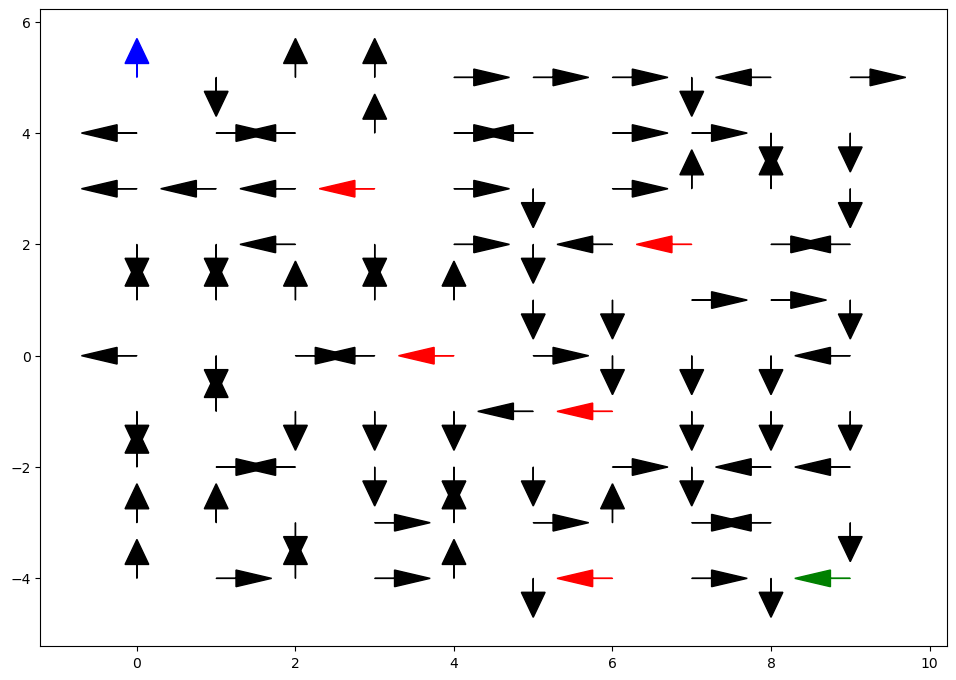

0.7 0.7


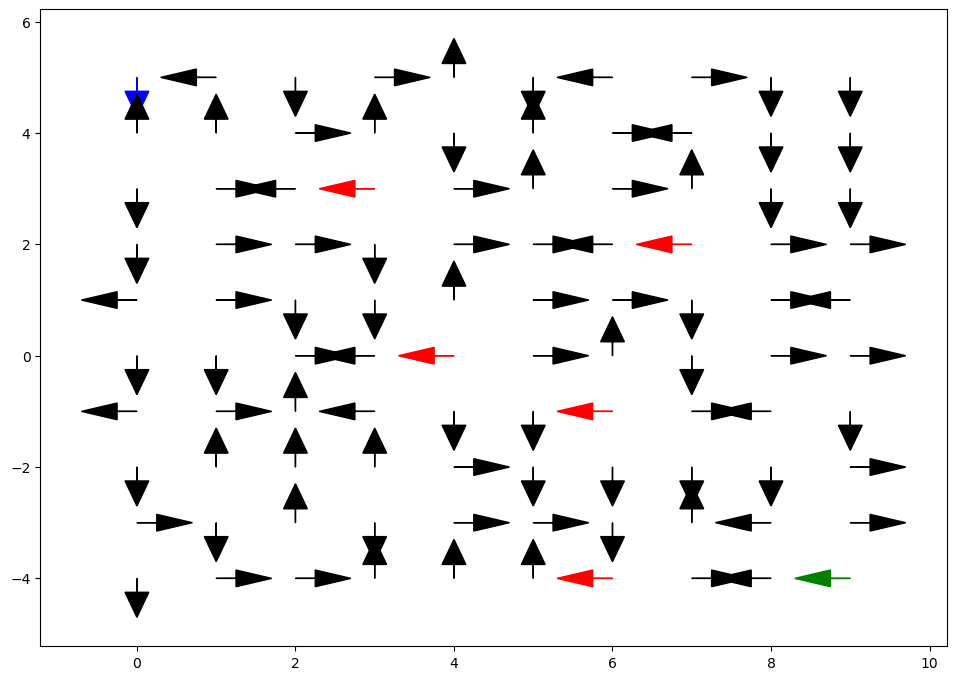

0.7 0.5


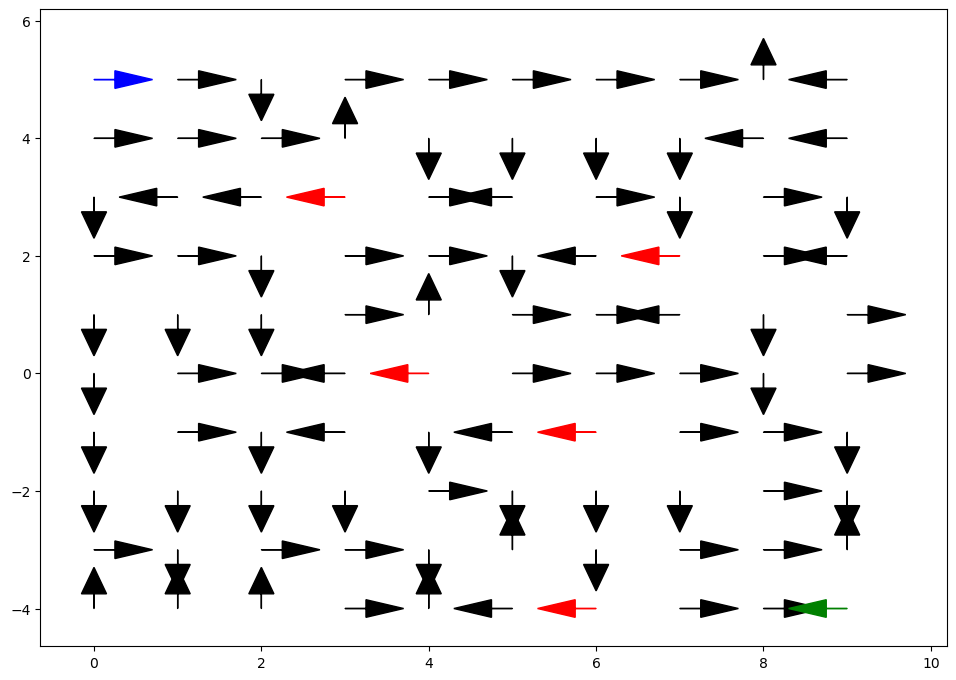

0.7 0.4


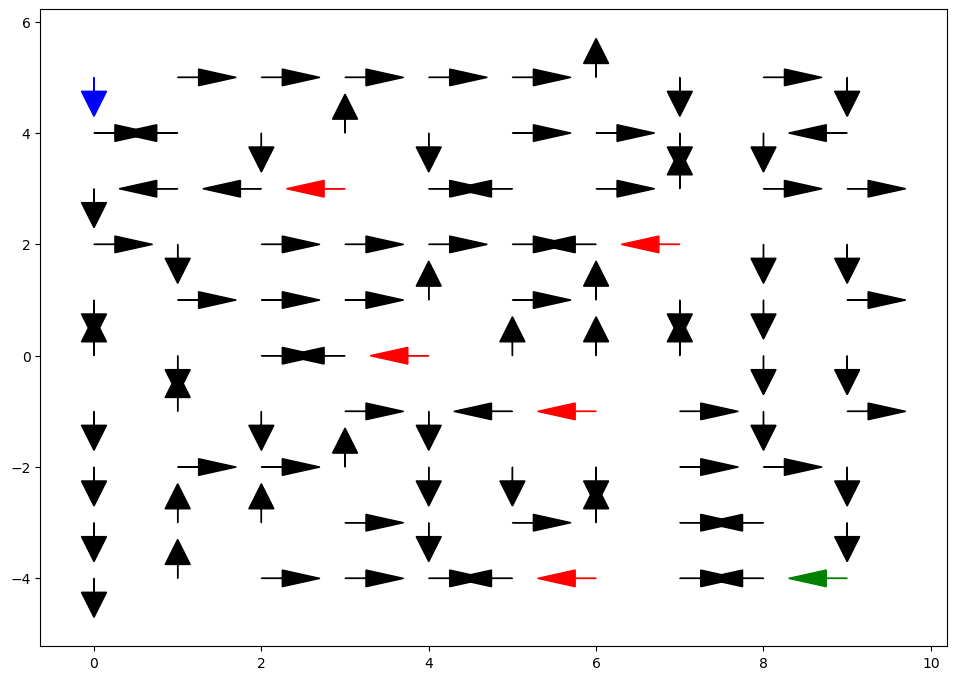

0.7 0.1


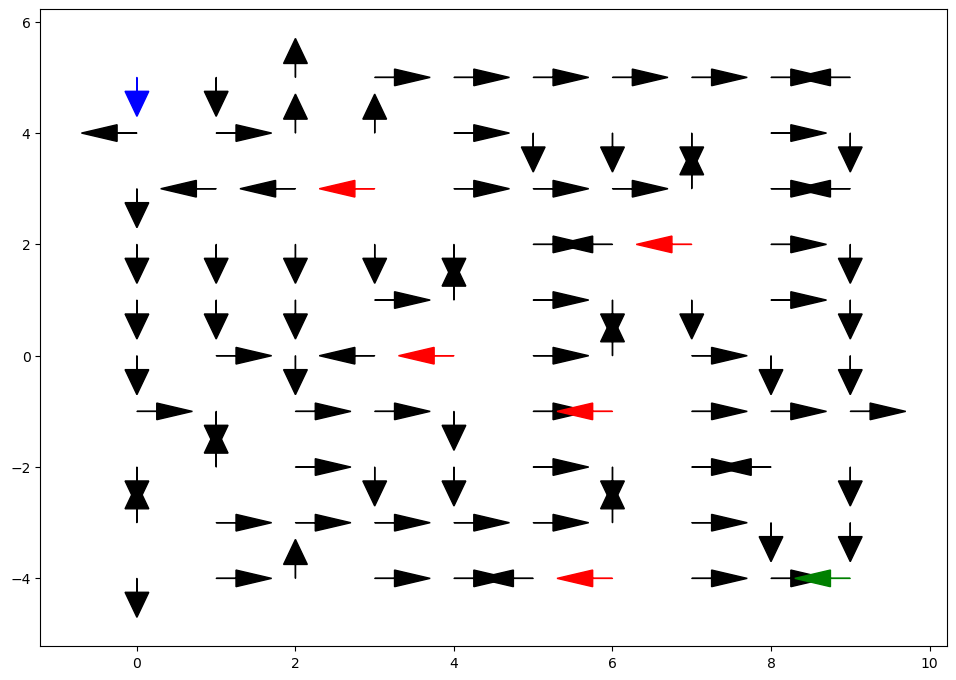

0.7 0.01


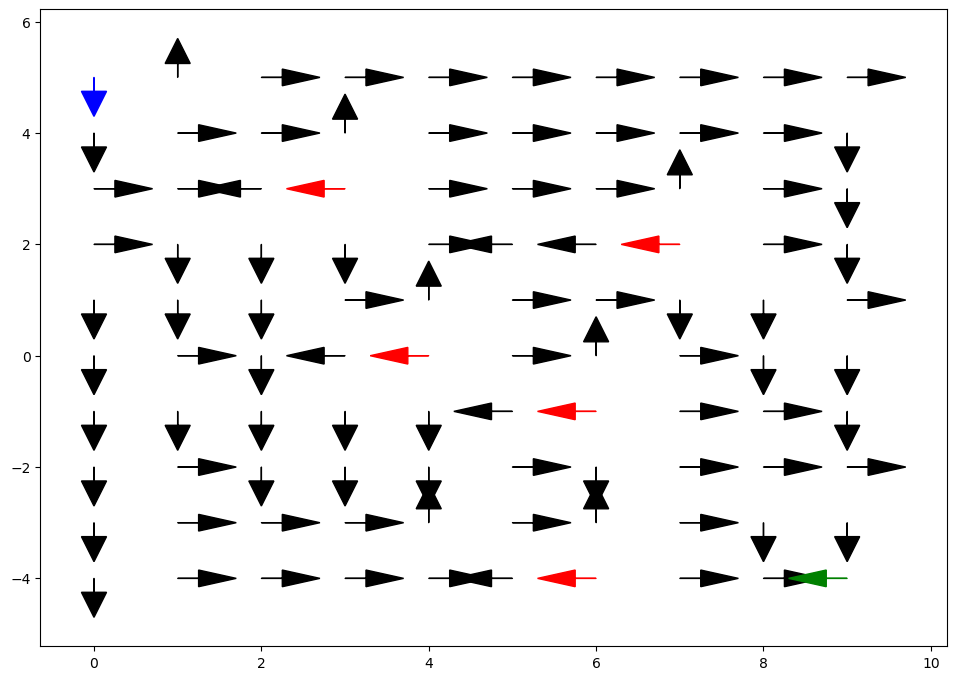

0.7 0.001


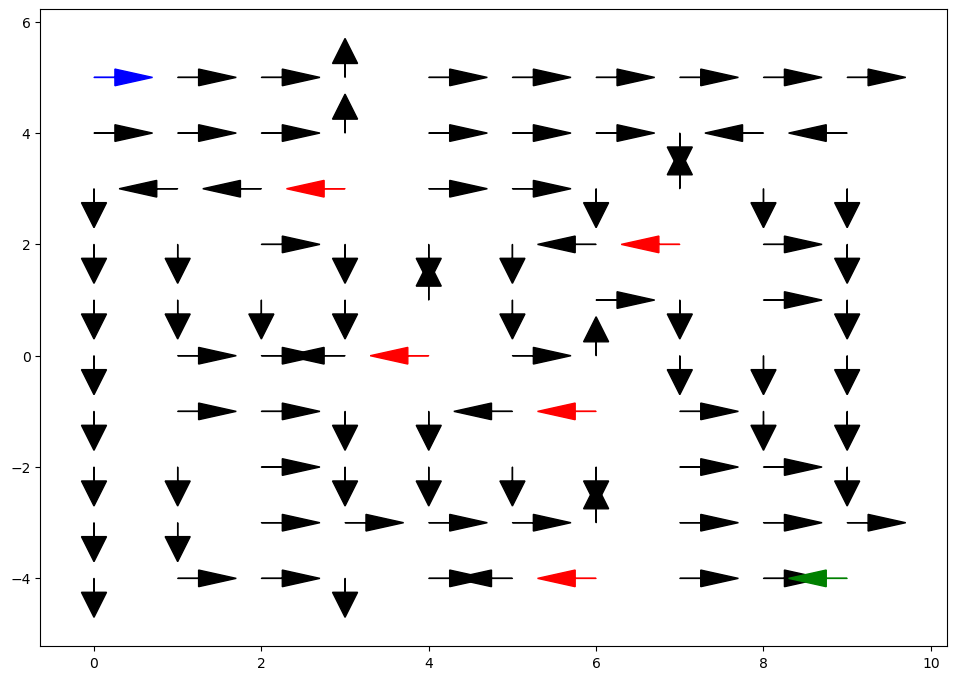

0.7 0.0001


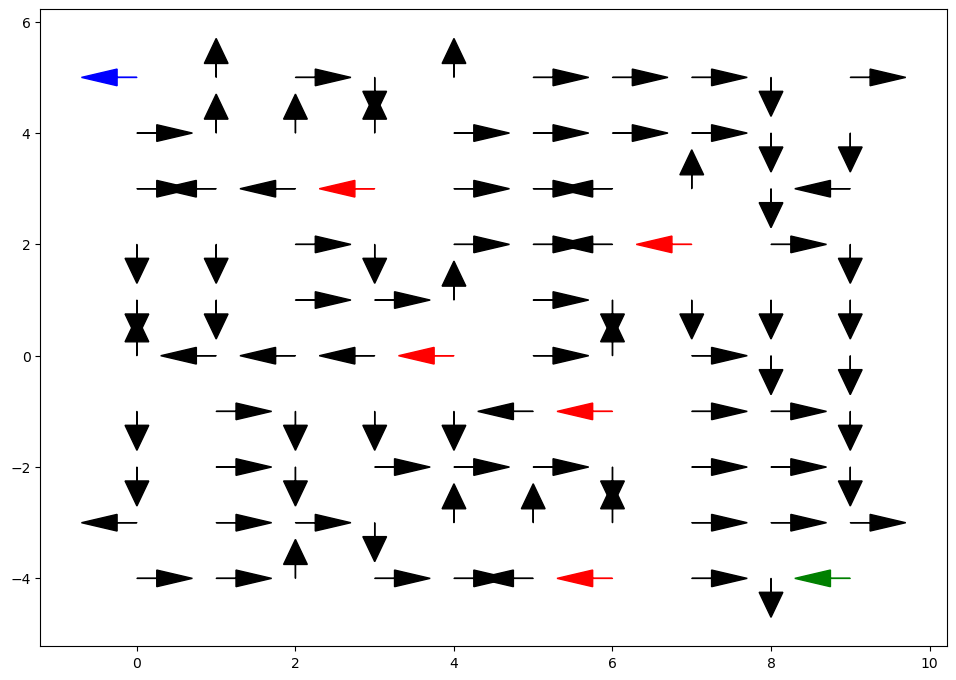

0.5 1


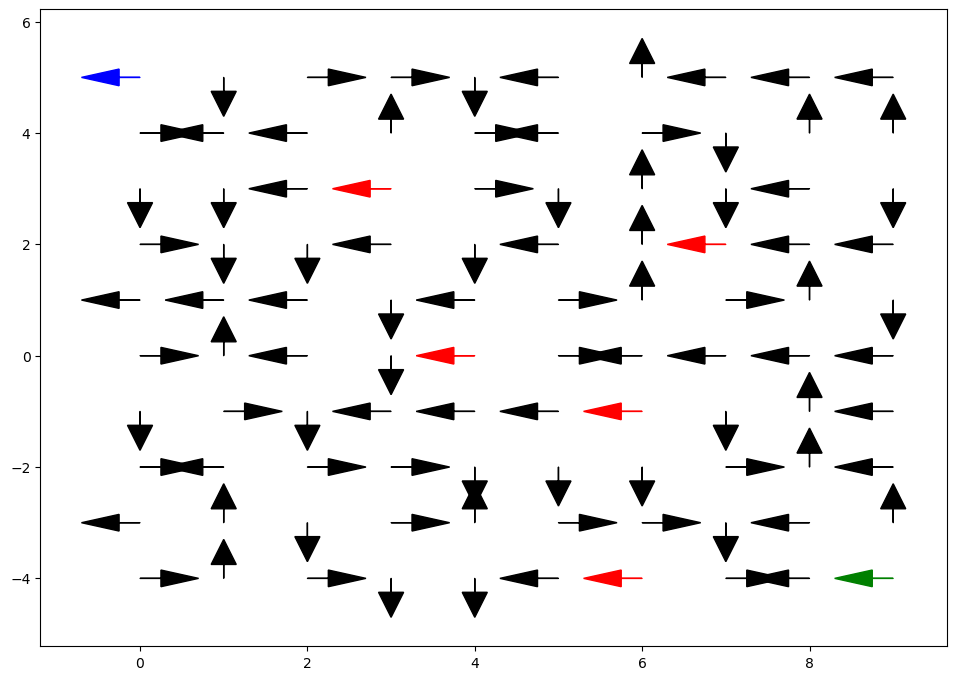

0.5 0.8


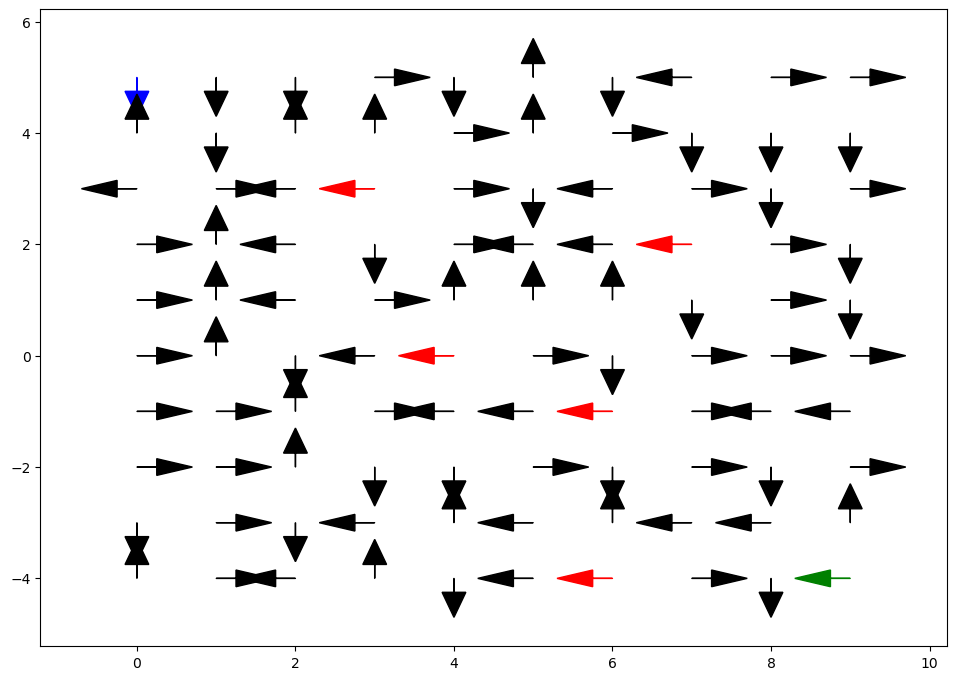

0.5 0.7


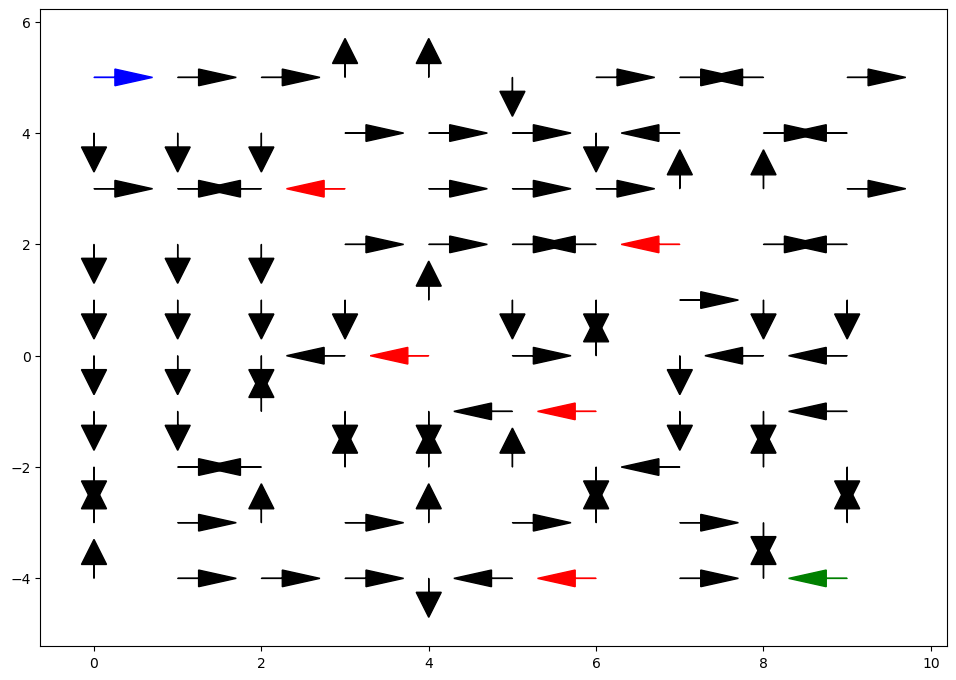

0.5 0.5


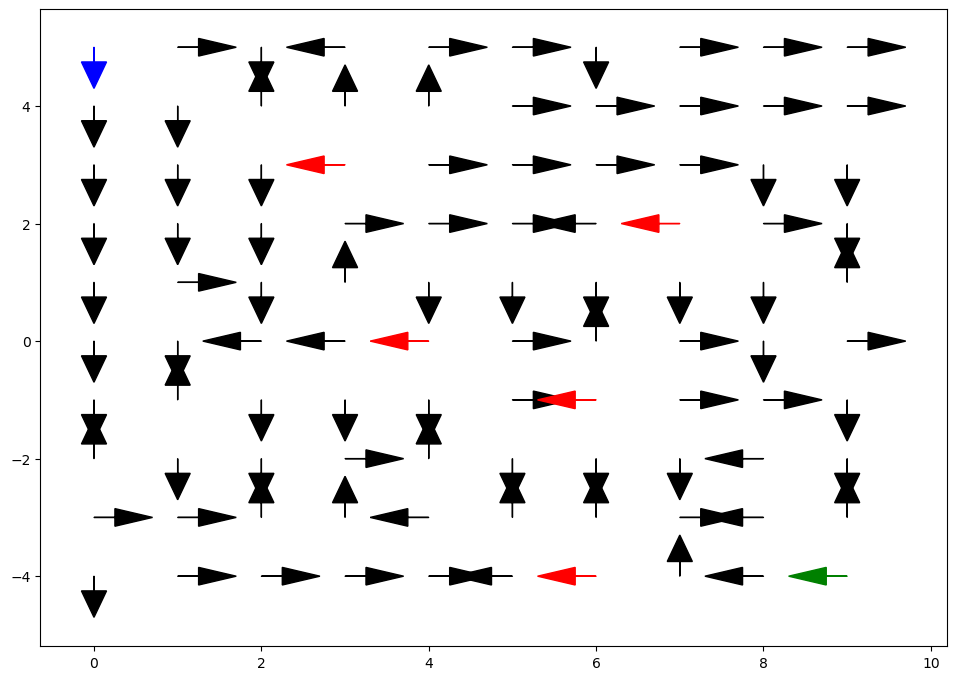

0.5 0.4


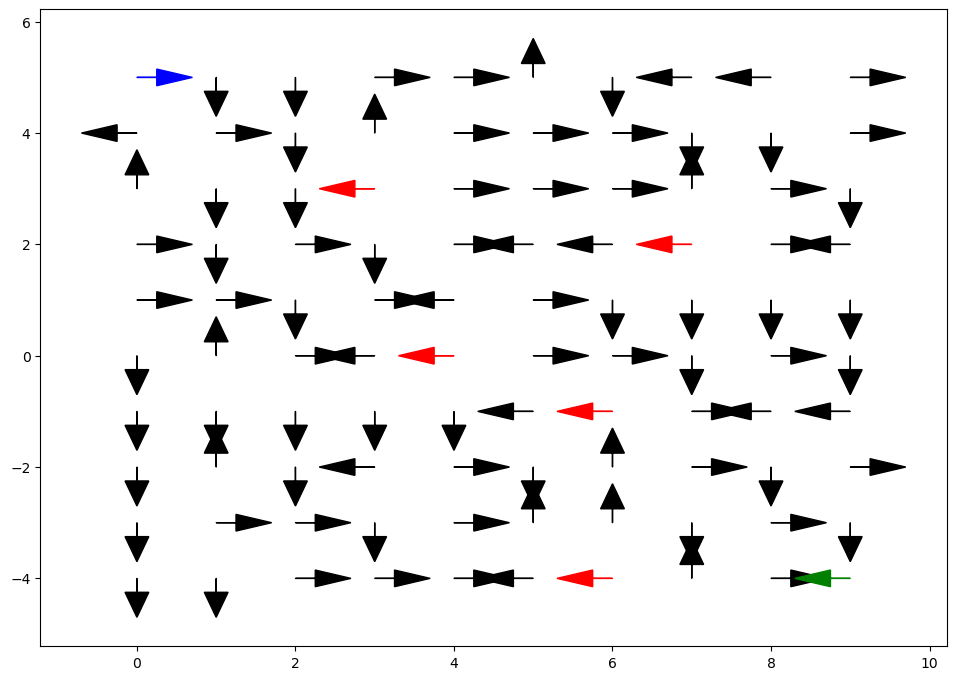

0.5 0.1


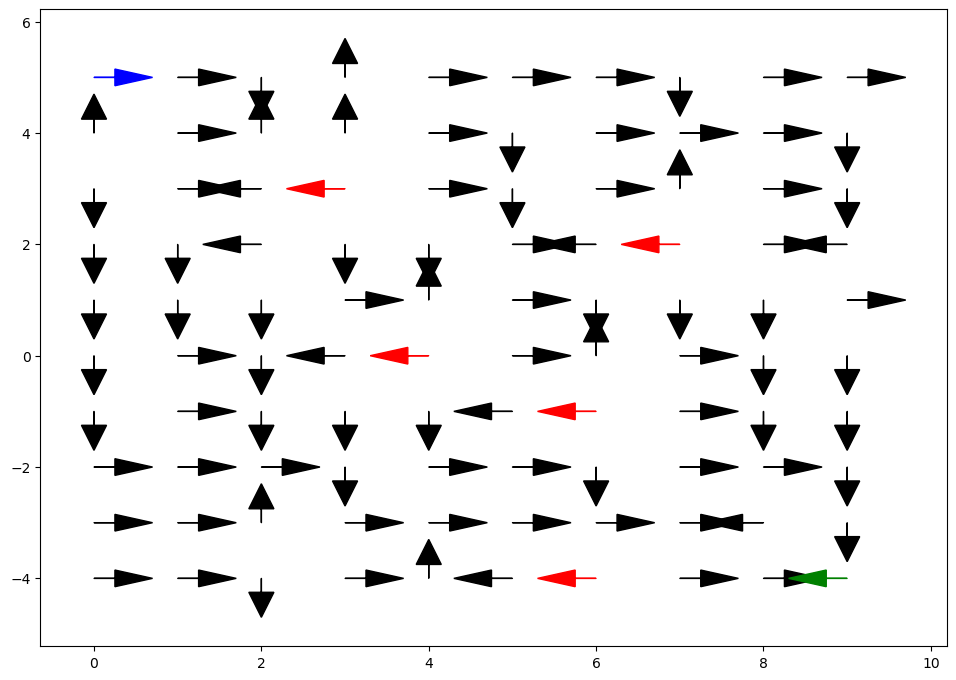

0.5 0.01


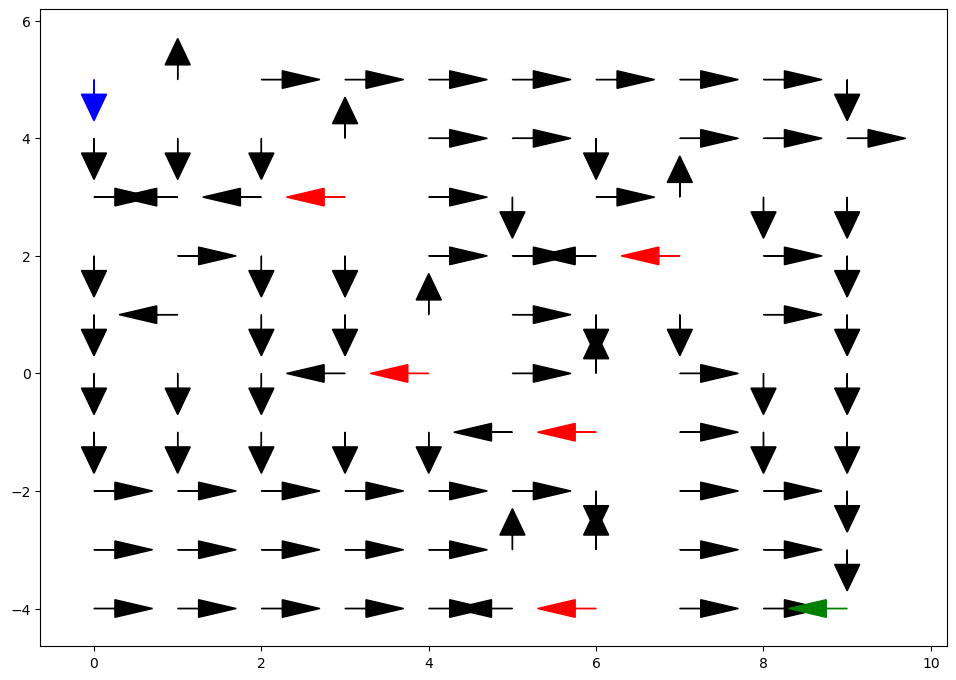

0.5 0.001


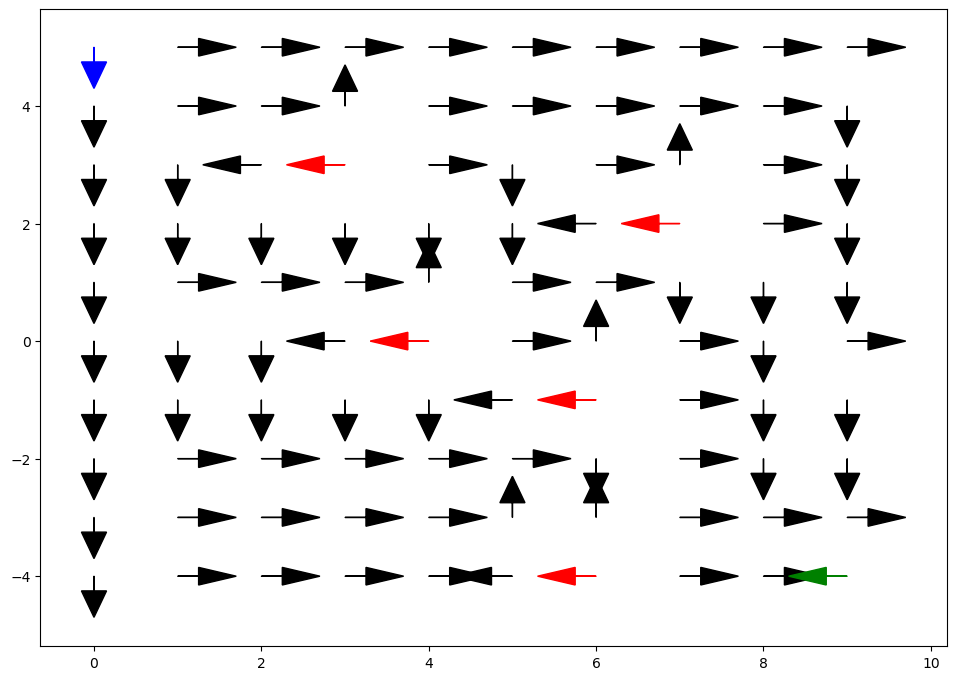

0.5 0.0001


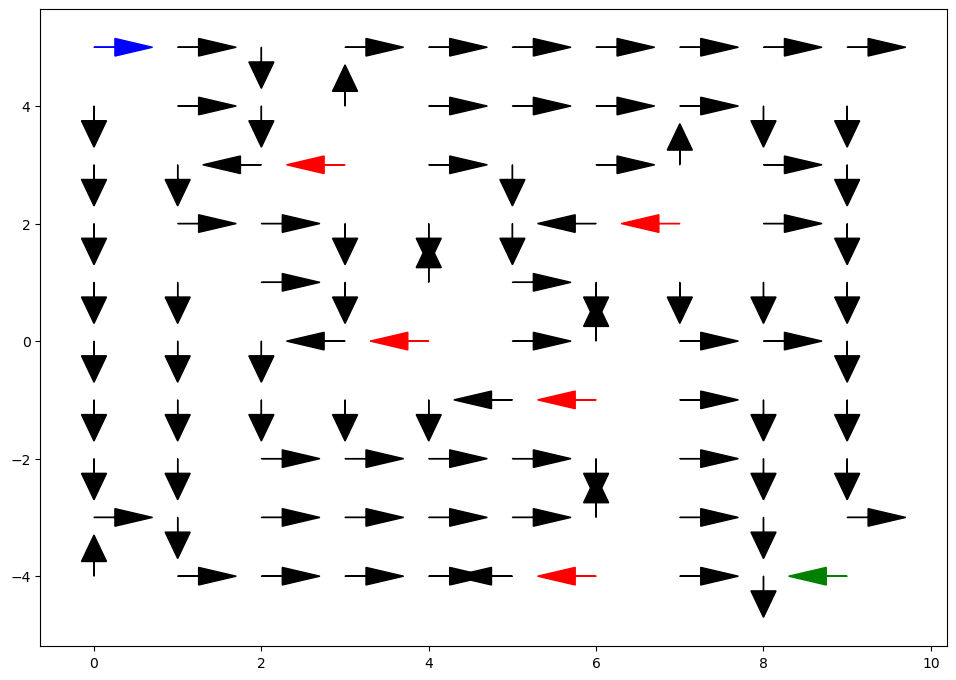

0.4 1


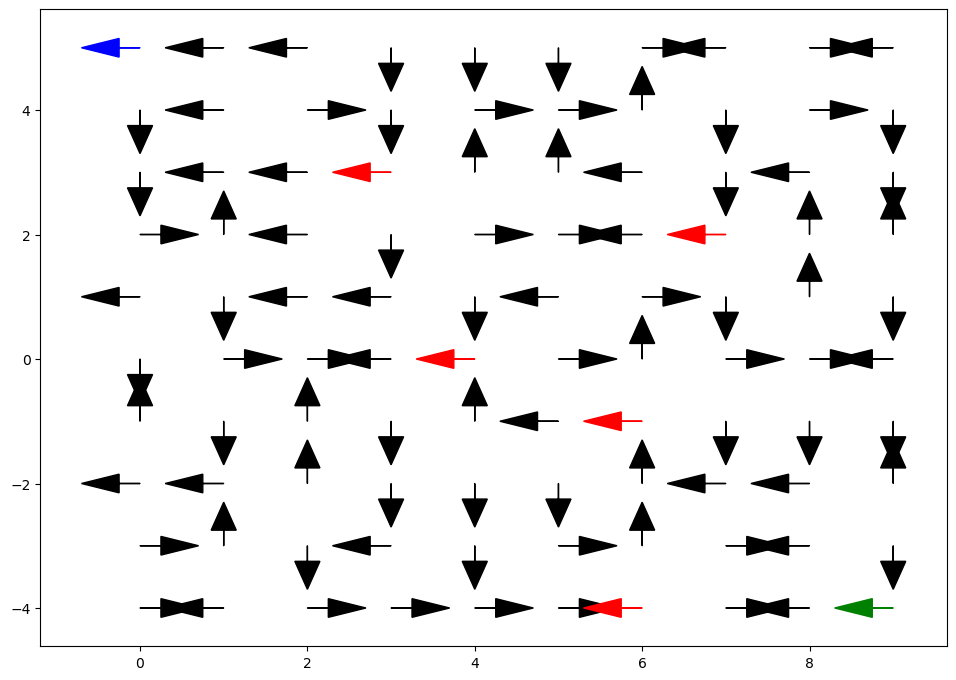

0.4 0.8


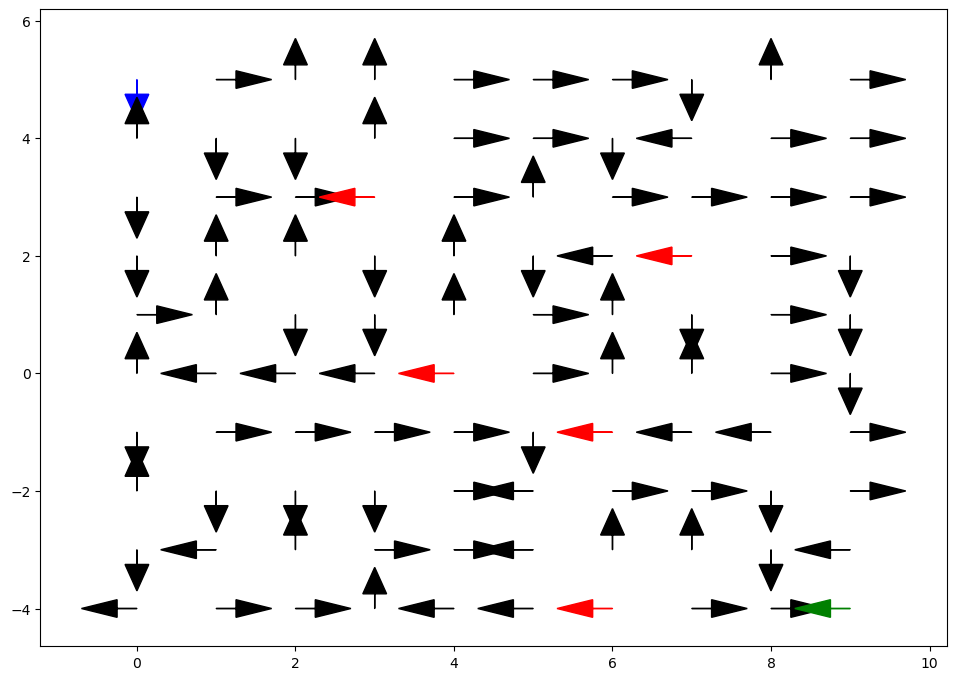

0.4 0.7


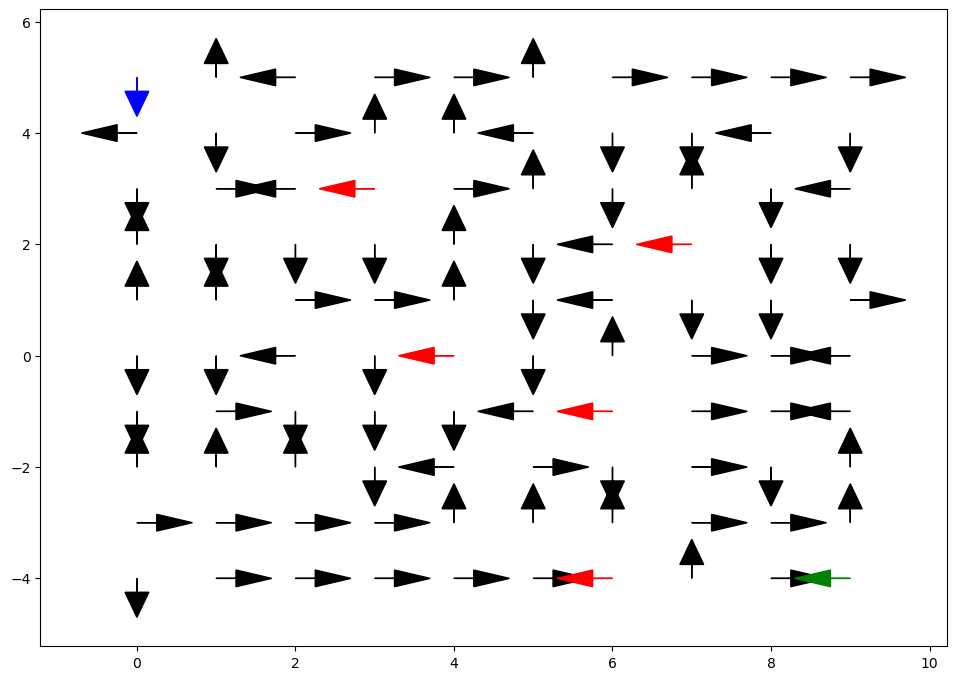

0.4 0.5


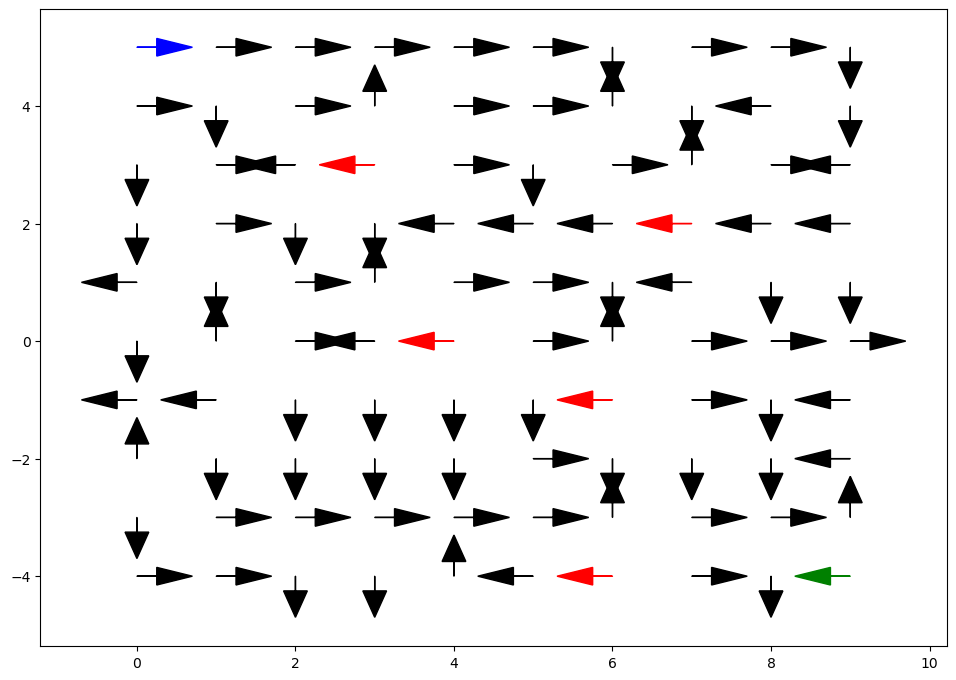

0.4 0.4


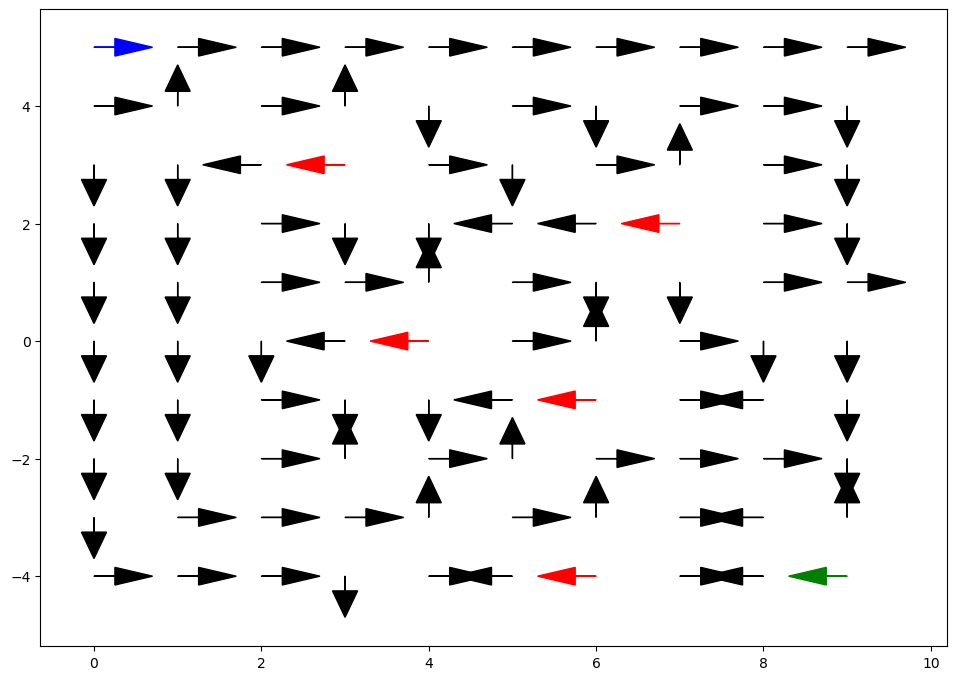

0.4 0.1


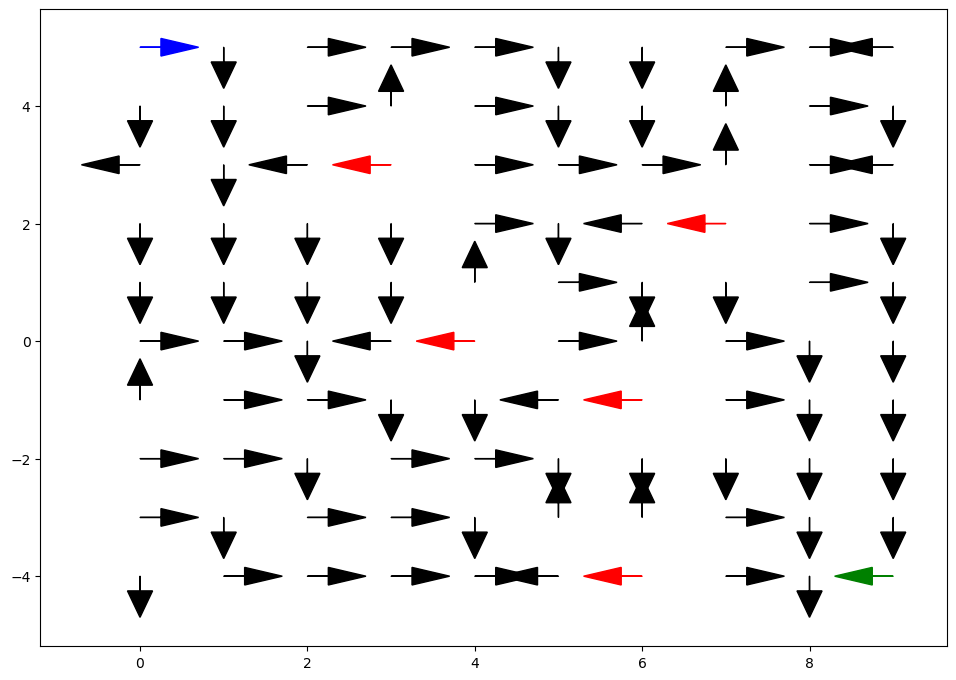

0.4 0.01


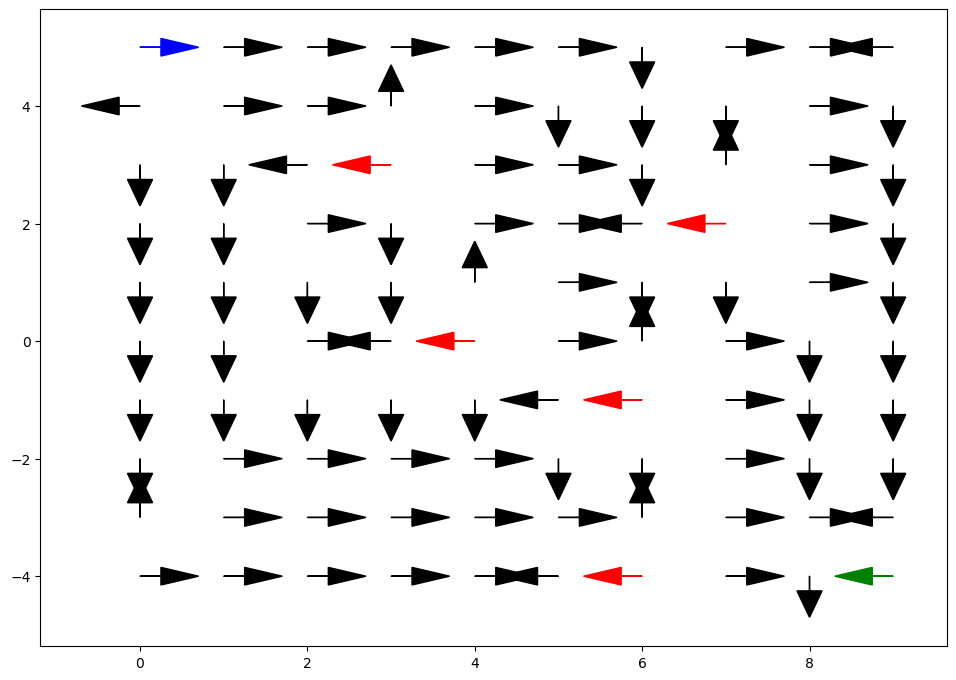

0.4 0.001


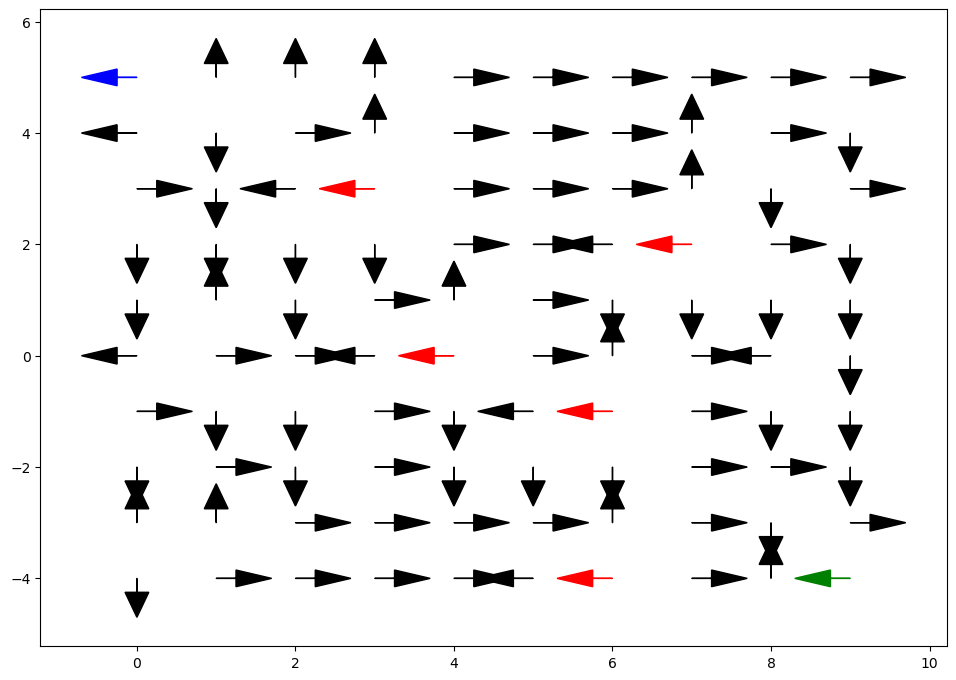

0.4 0.0001


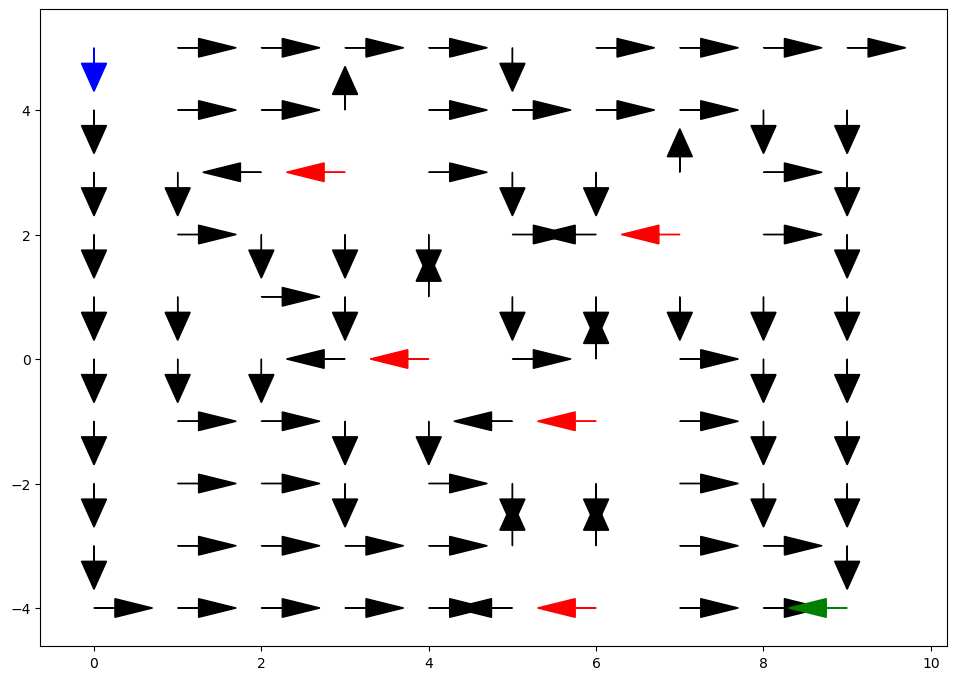

0.1 1


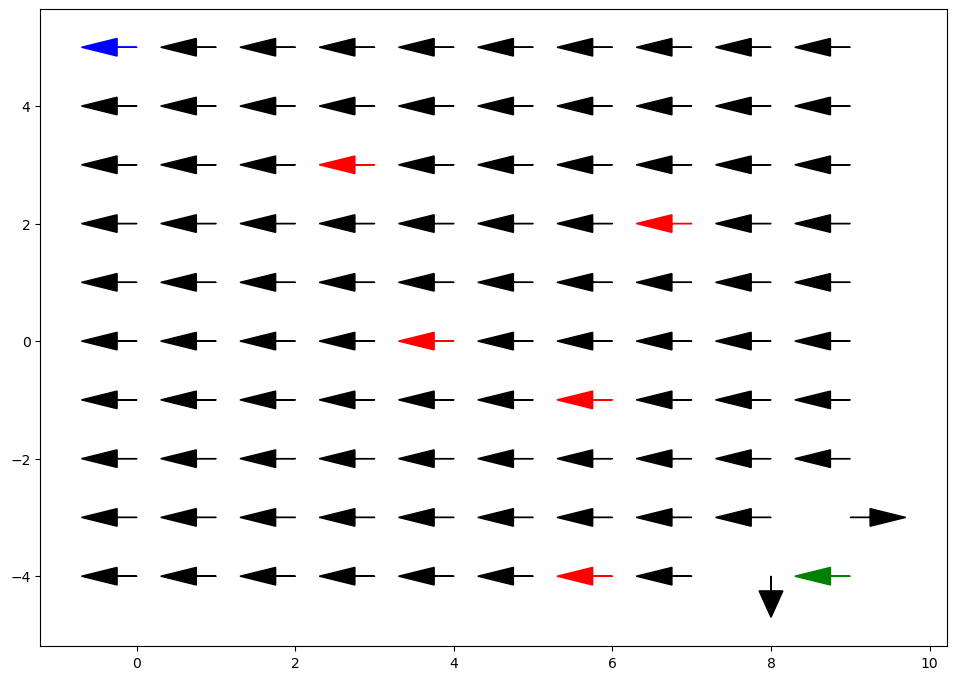

0.1 0.8


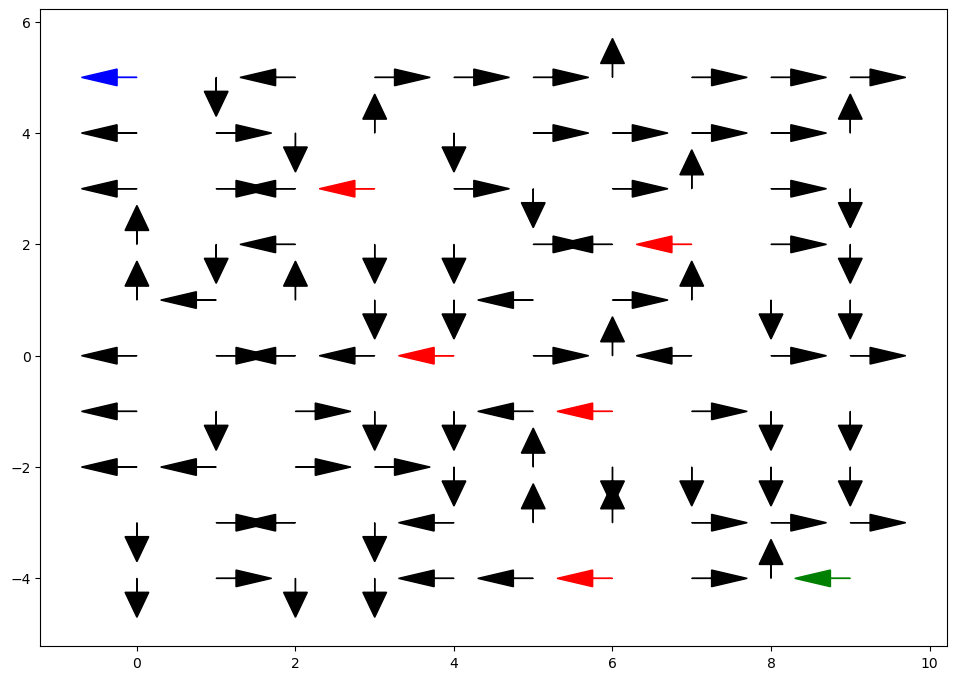

0.1 0.7


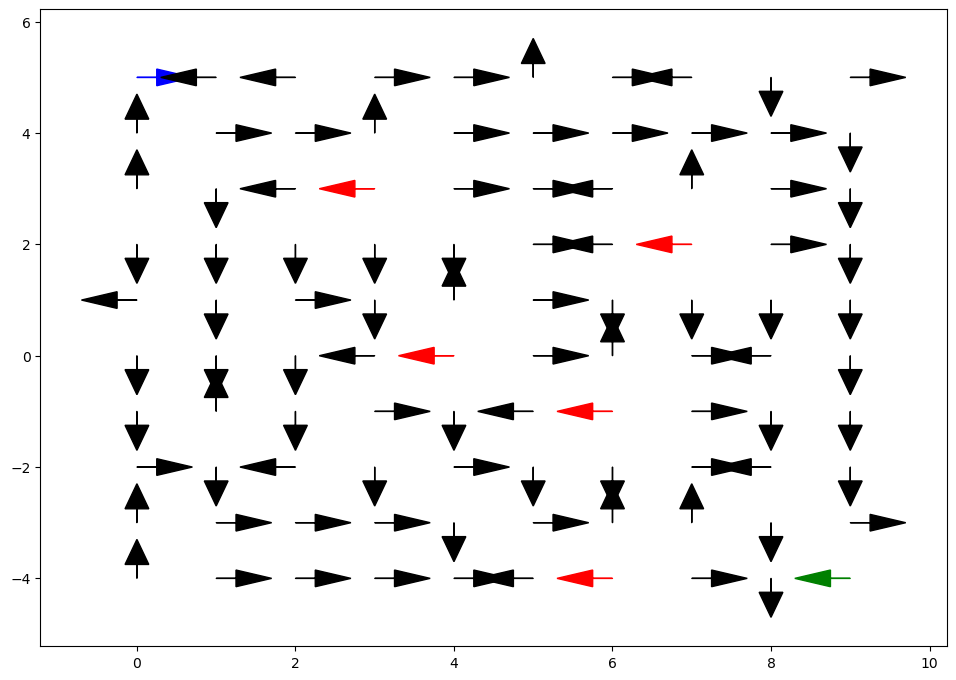

0.1 0.5


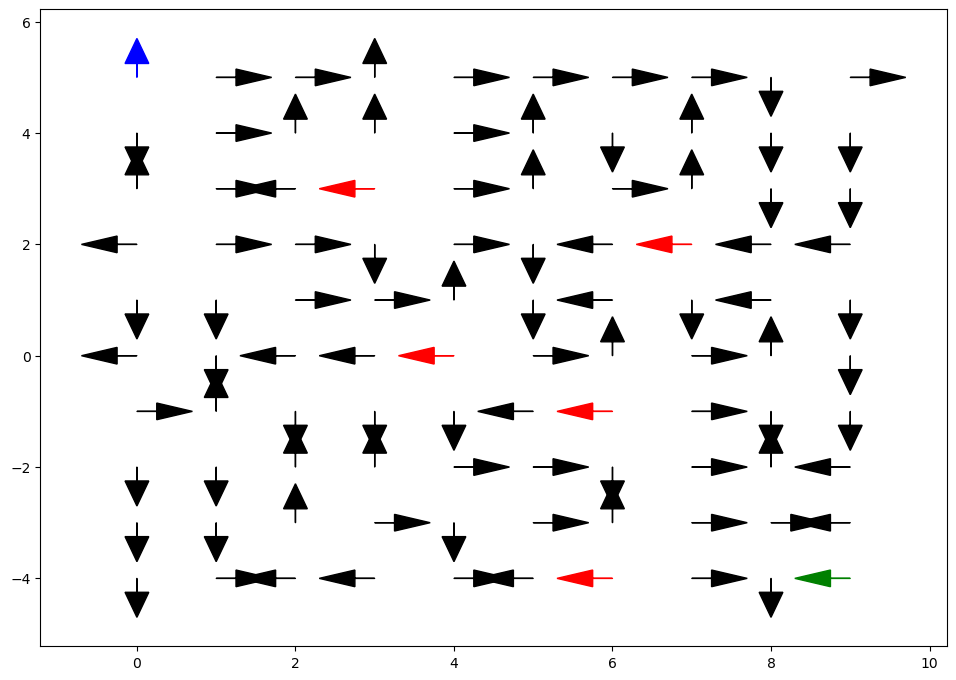

0.1 0.4


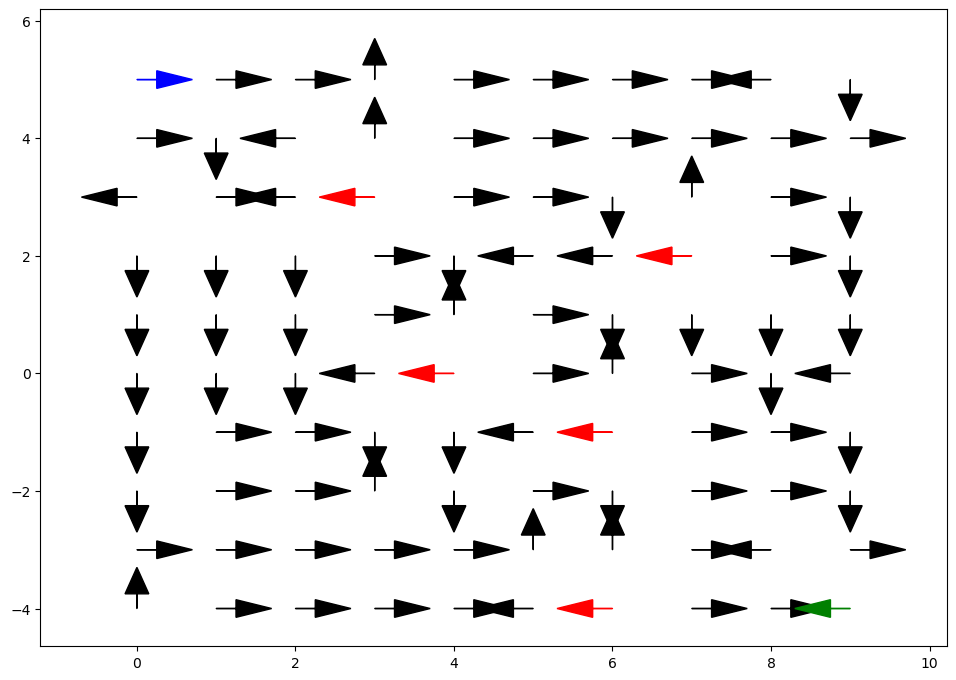

0.1 0.1


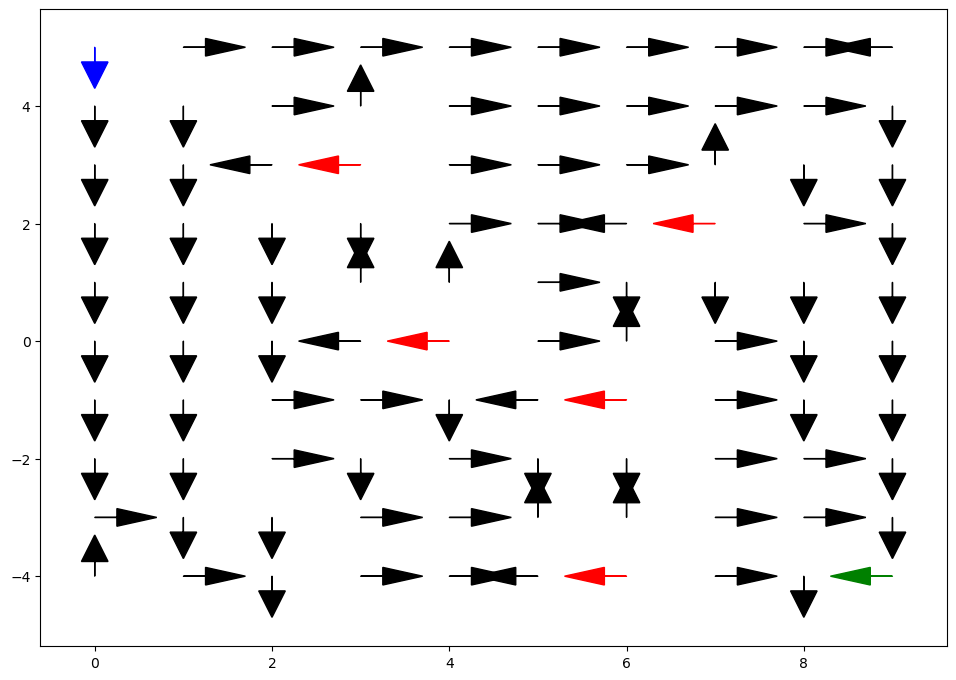

0.1 0.01


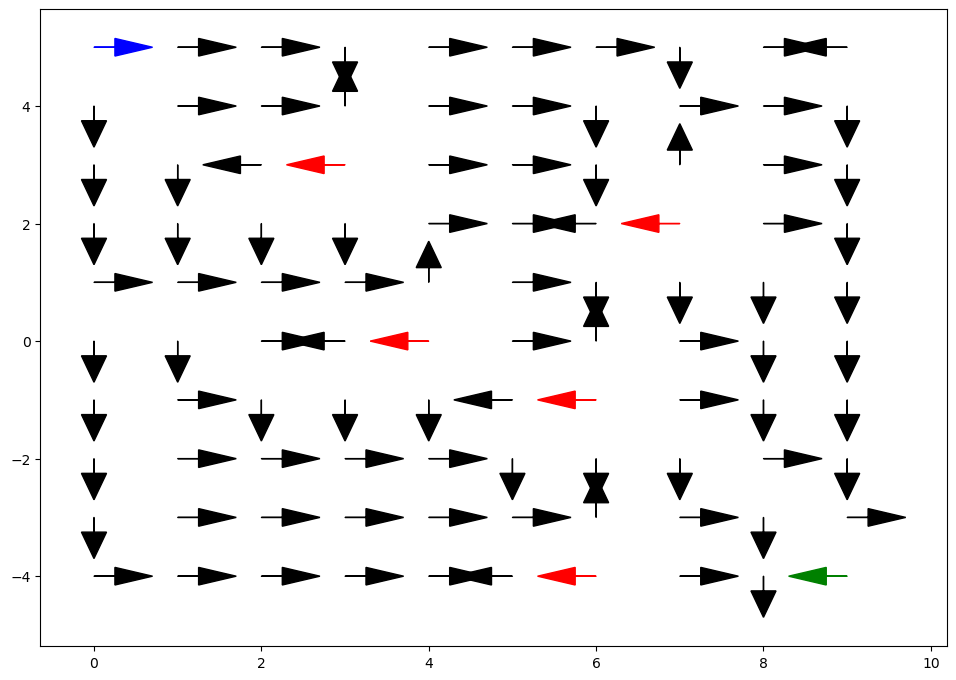

0.1 0.001


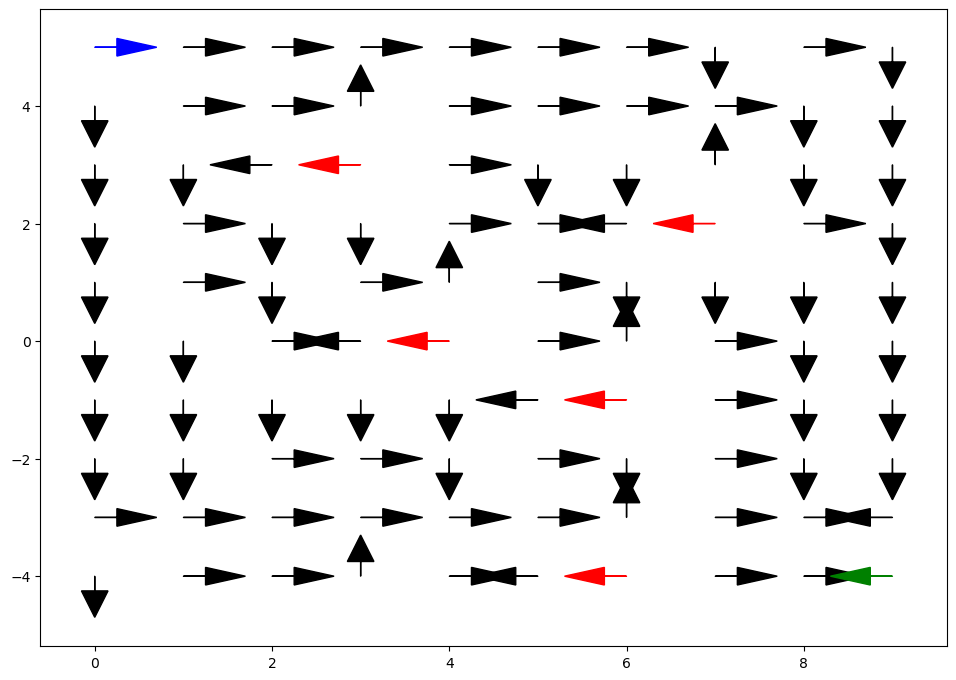

0.1 0.0001


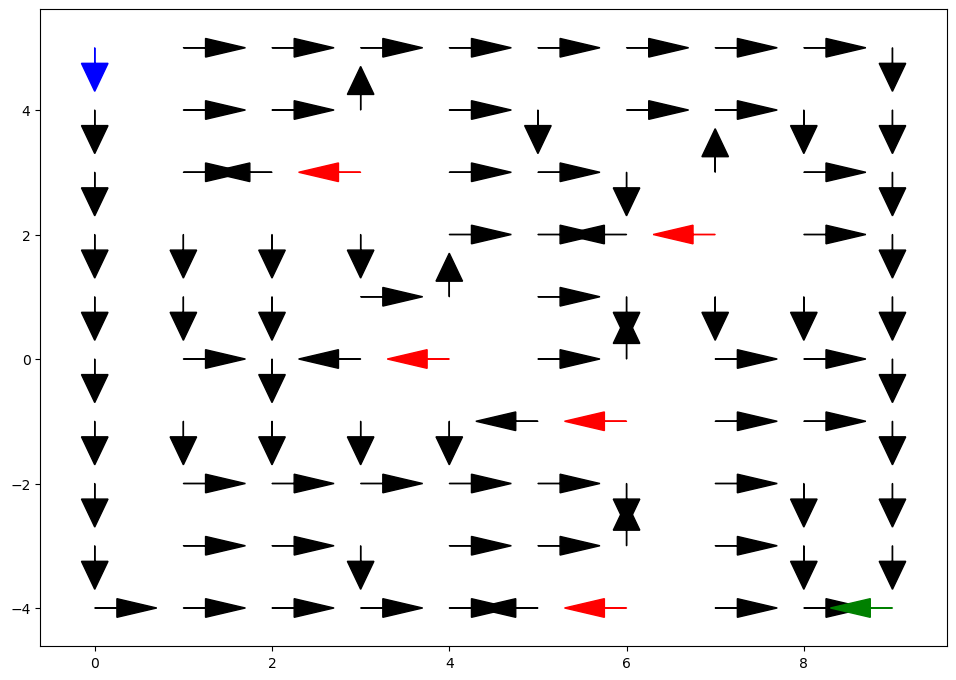

0.01 1


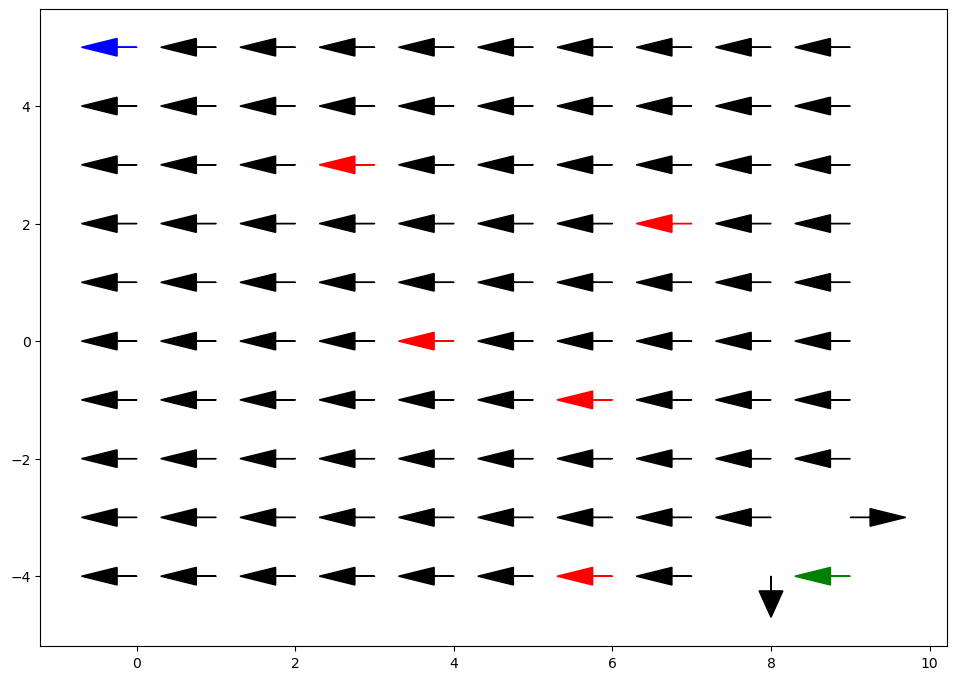

0.01 0.8


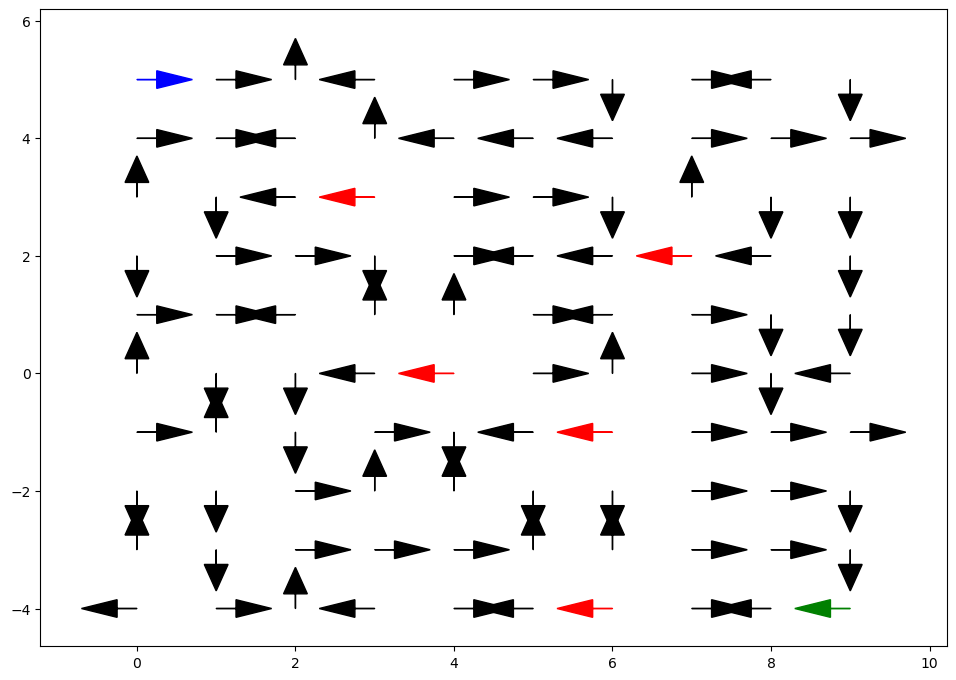

0.01 0.7


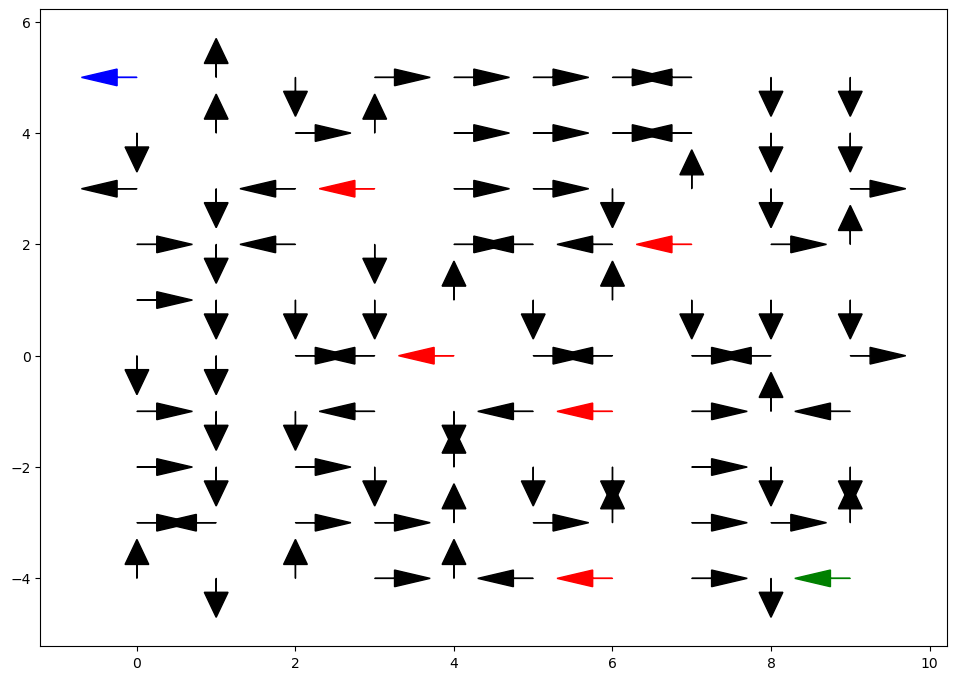

0.01 0.5


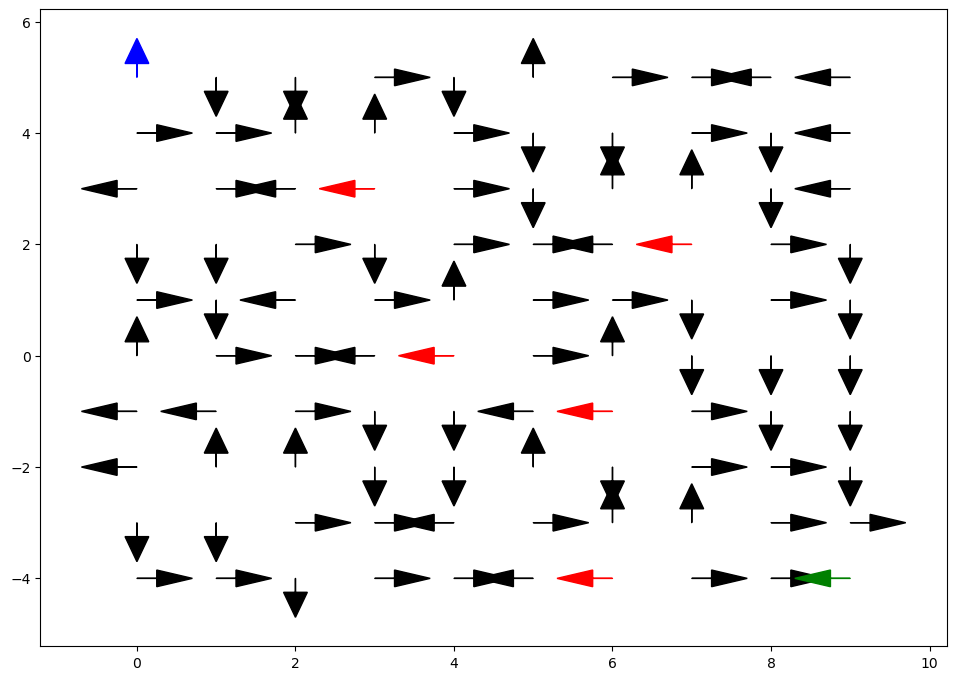

0.01 0.4


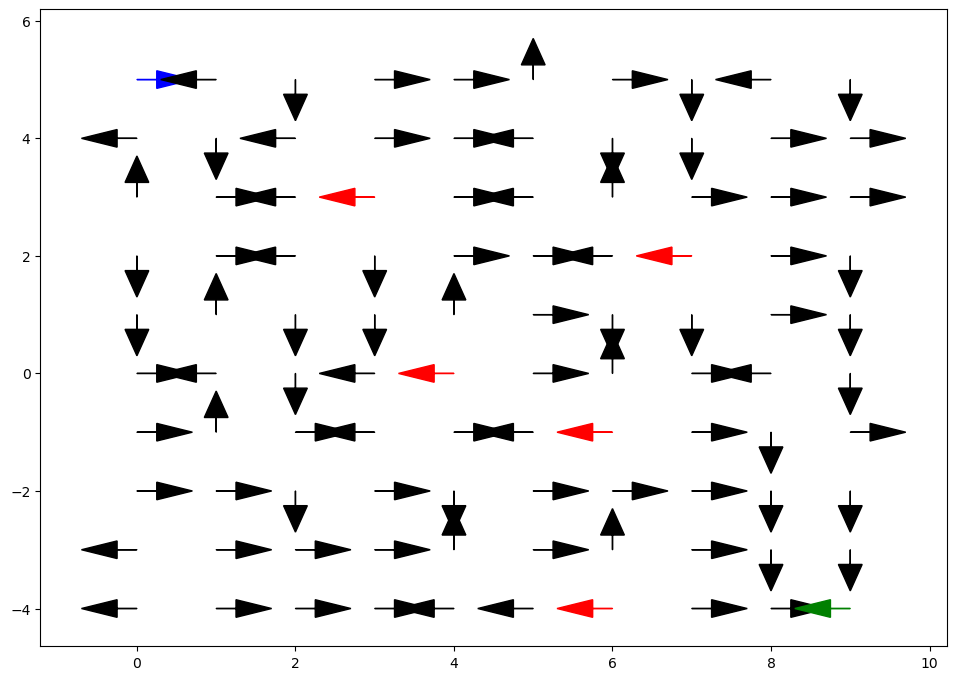

0.01 0.1


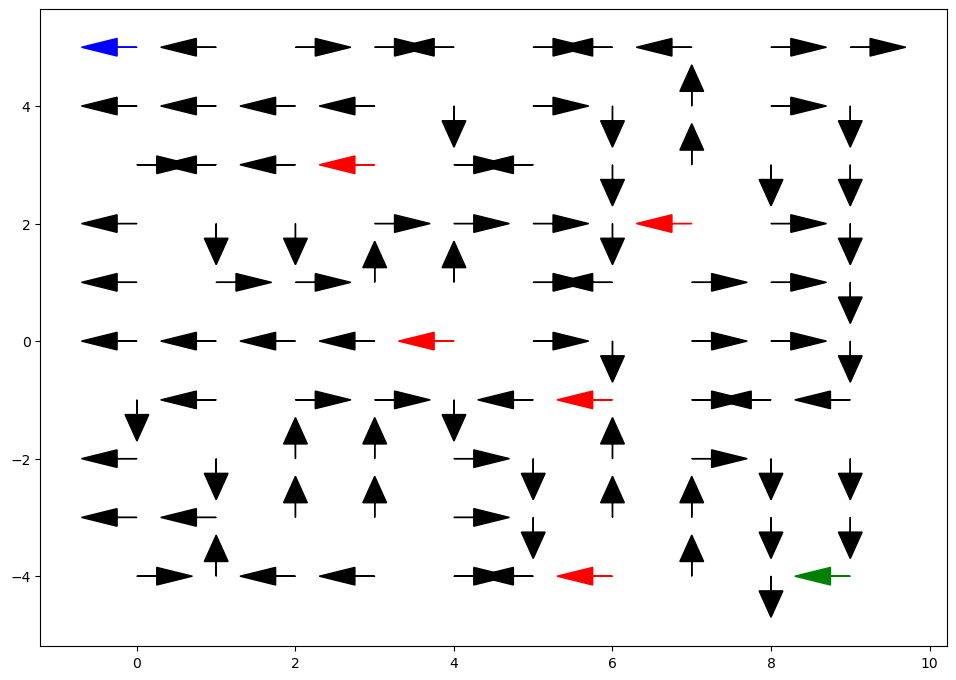

0.01 0.01


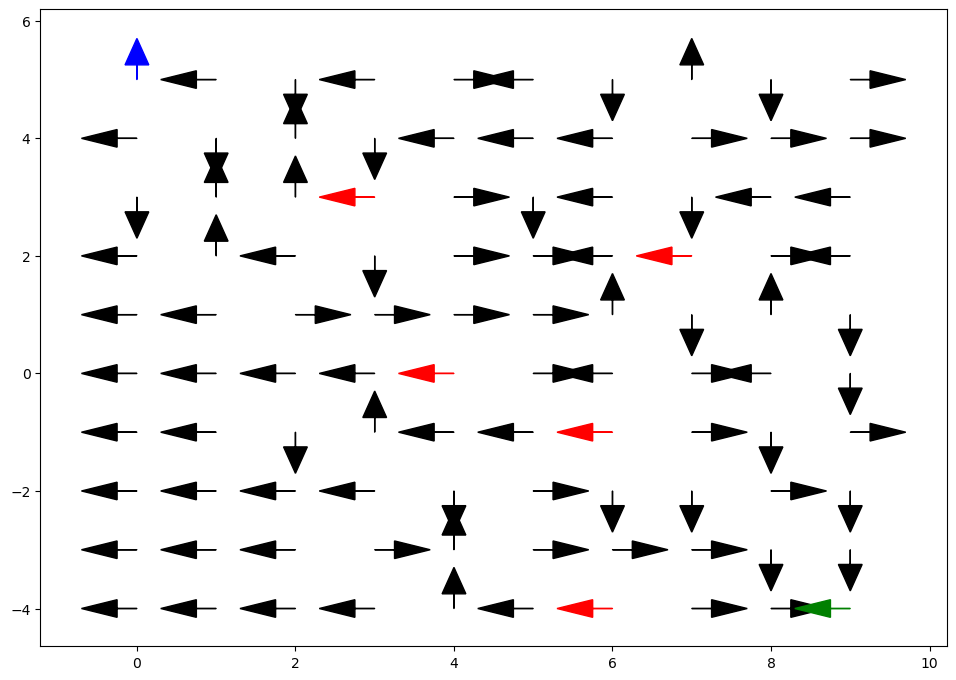

0.01 0.001


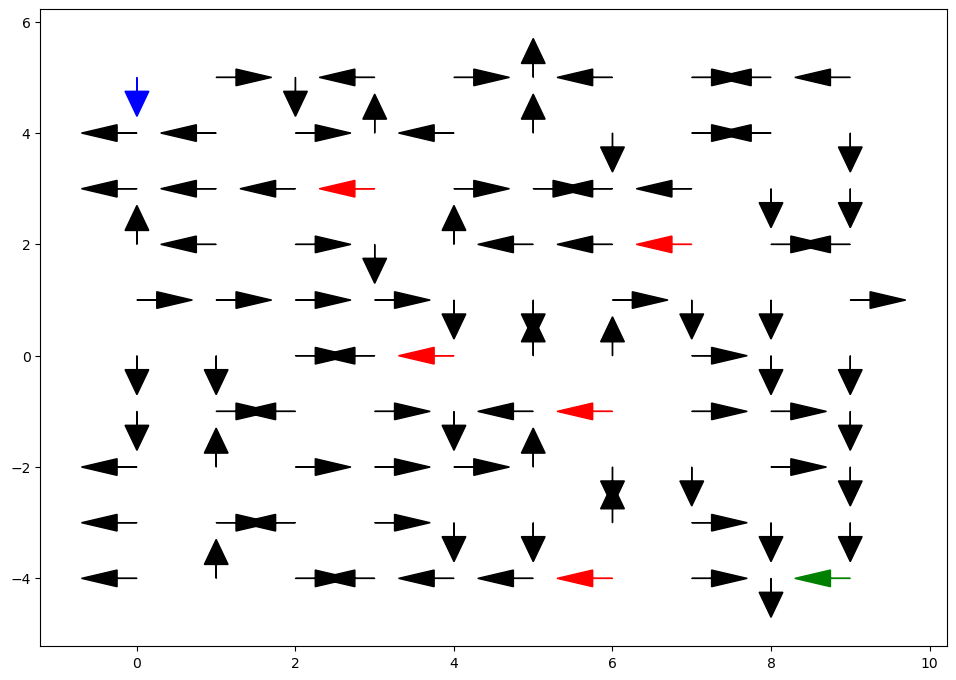

0.01 0.0001


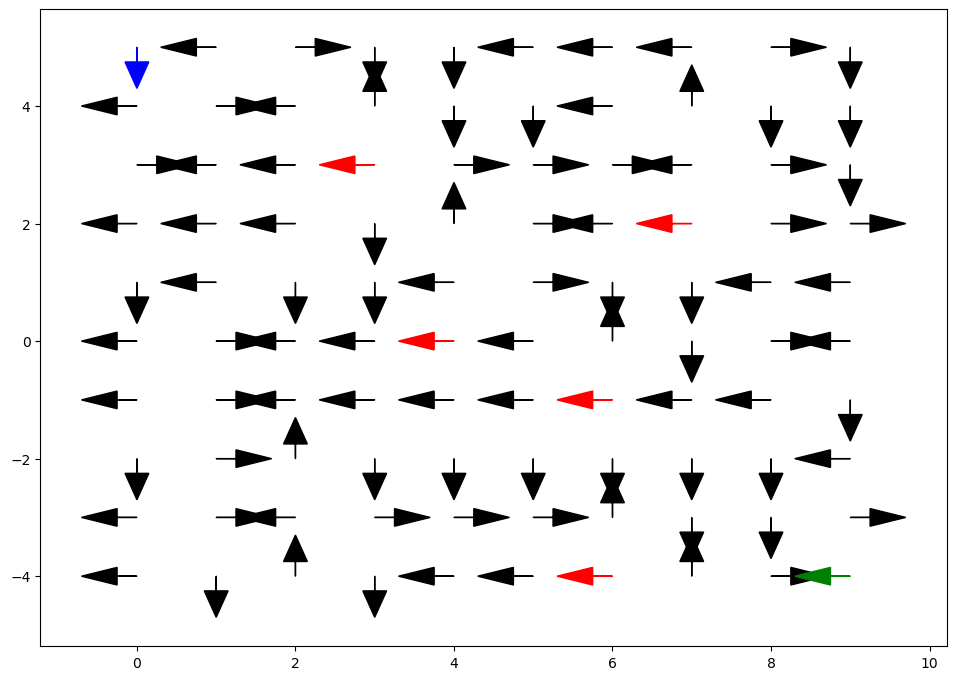

0.001 1


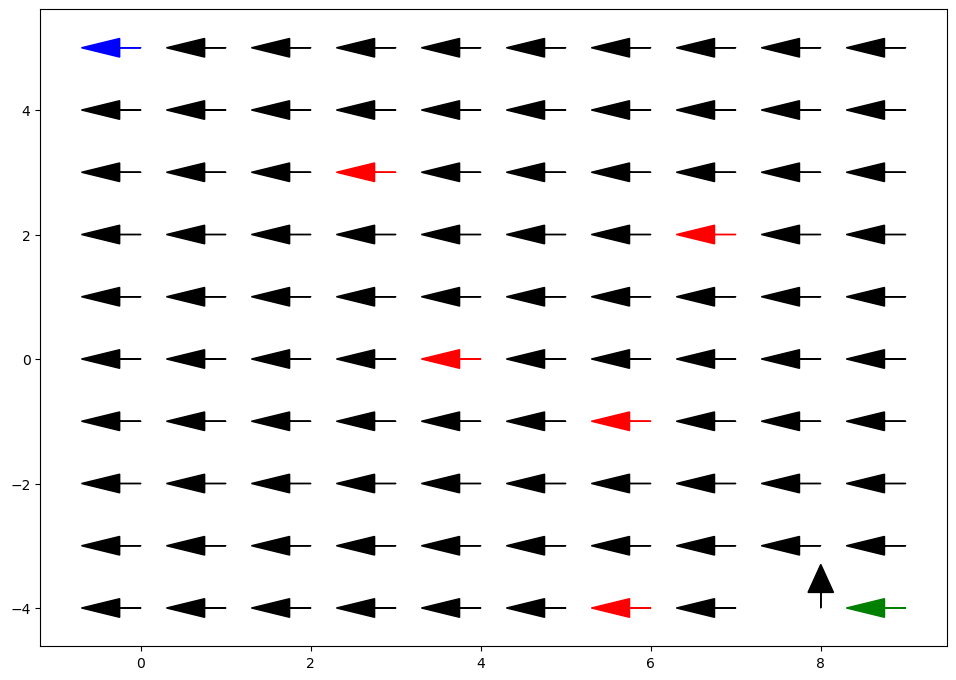

0.001 0.8


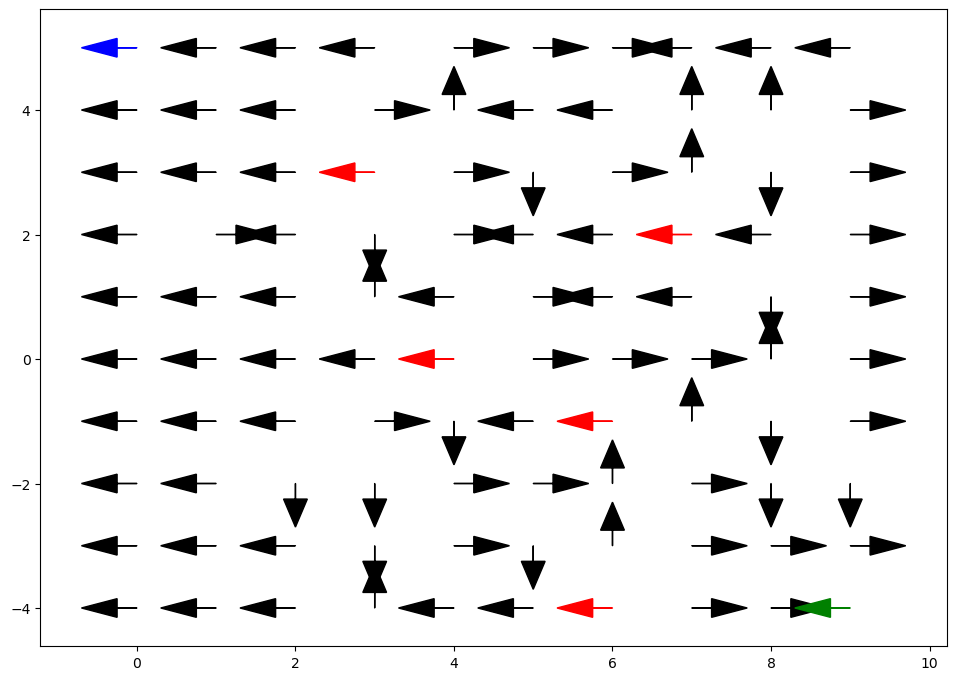

0.001 0.7


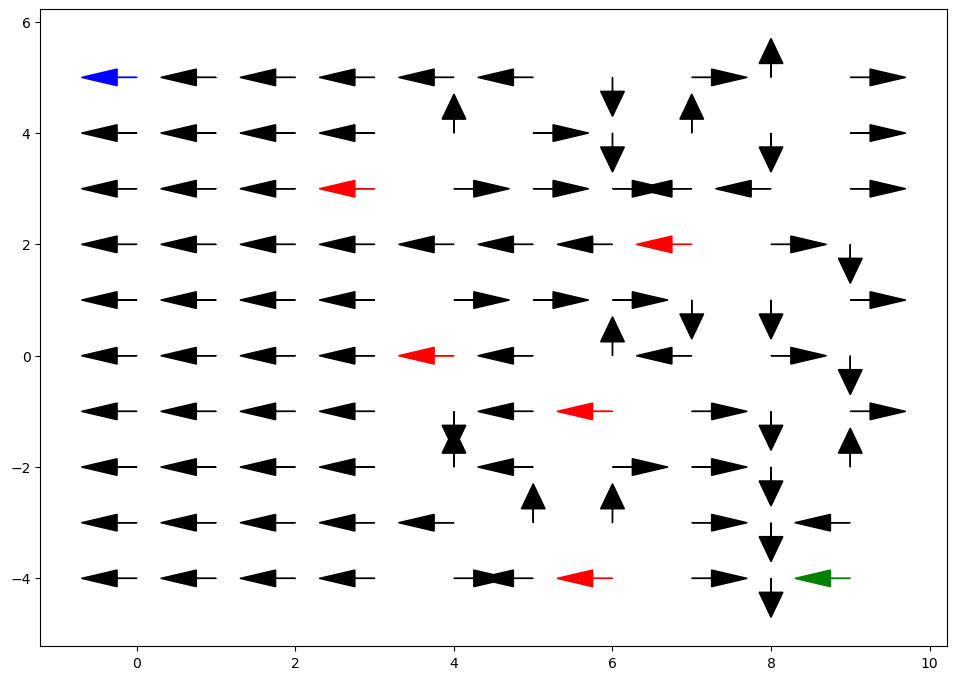

0.001 0.5


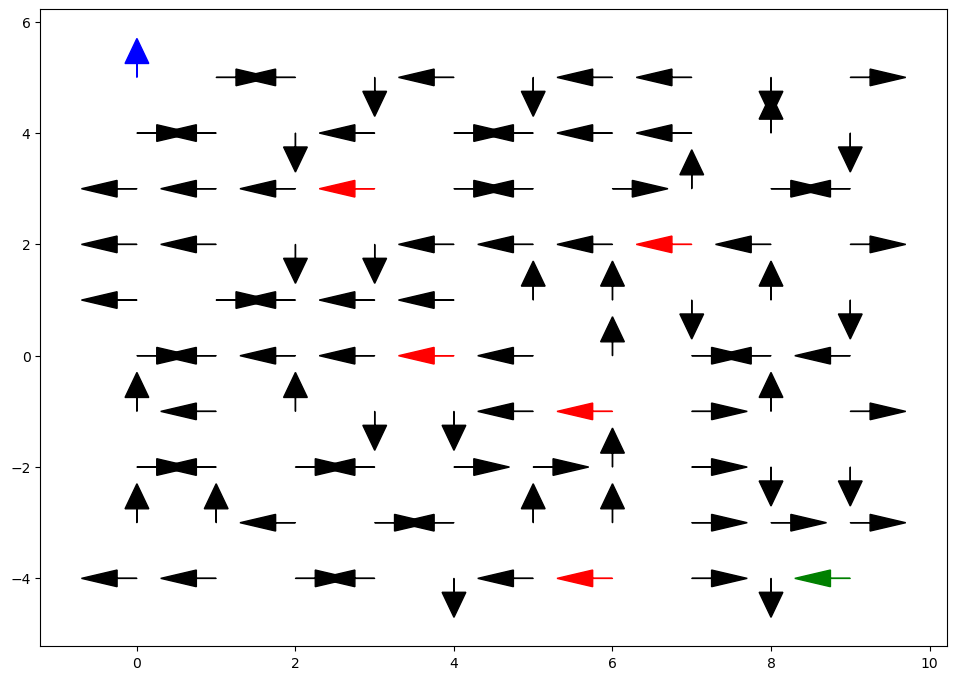

0.001 0.4


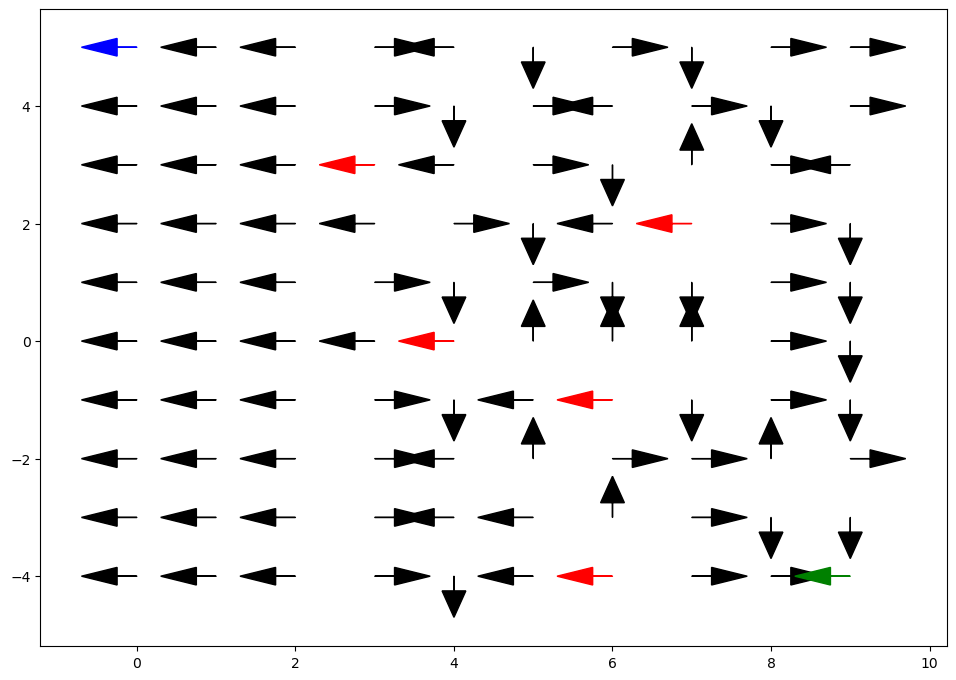

0.001 0.1


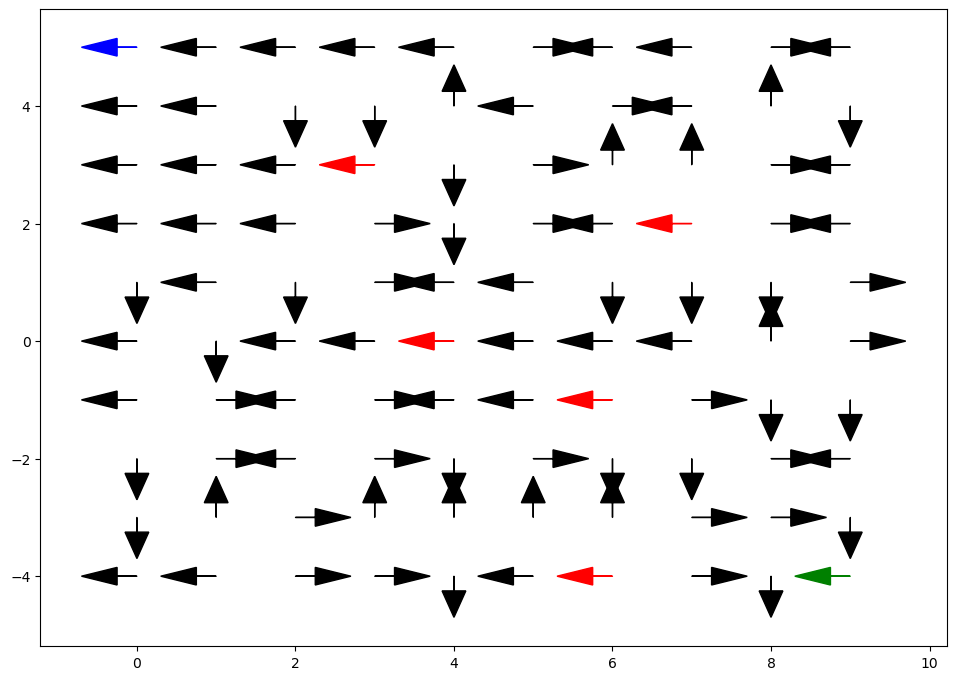

0.001 0.01


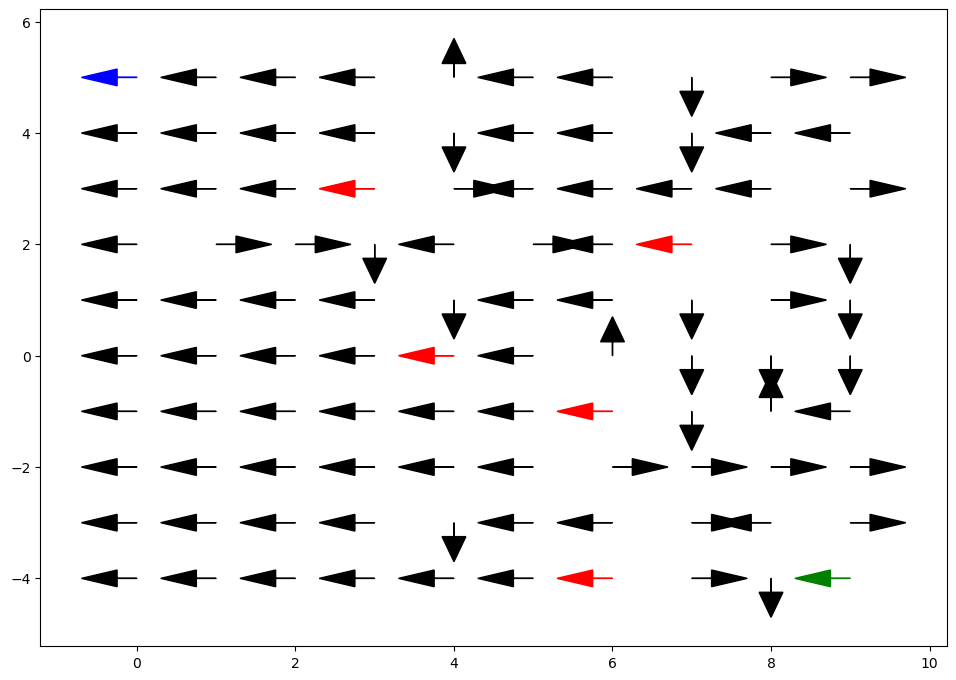

0.001 0.001


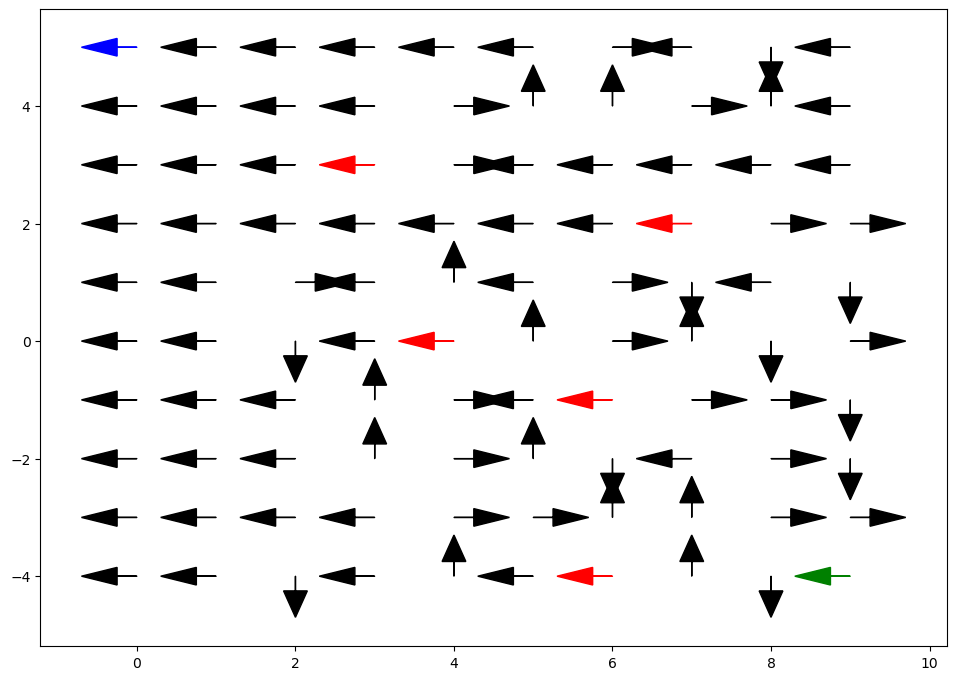

0.001 0.0001


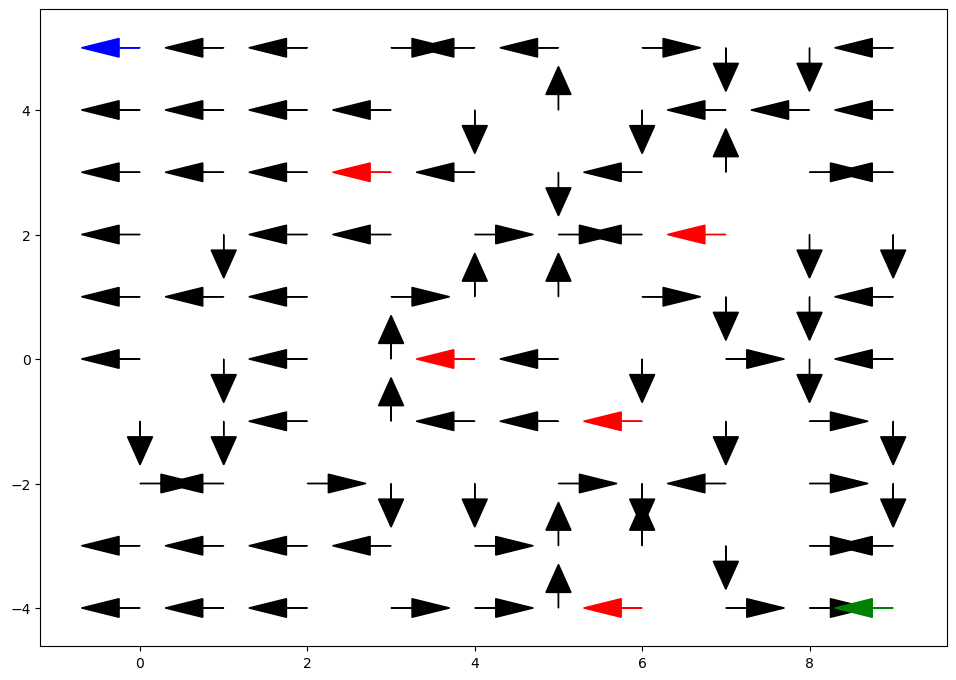

0.0001 1


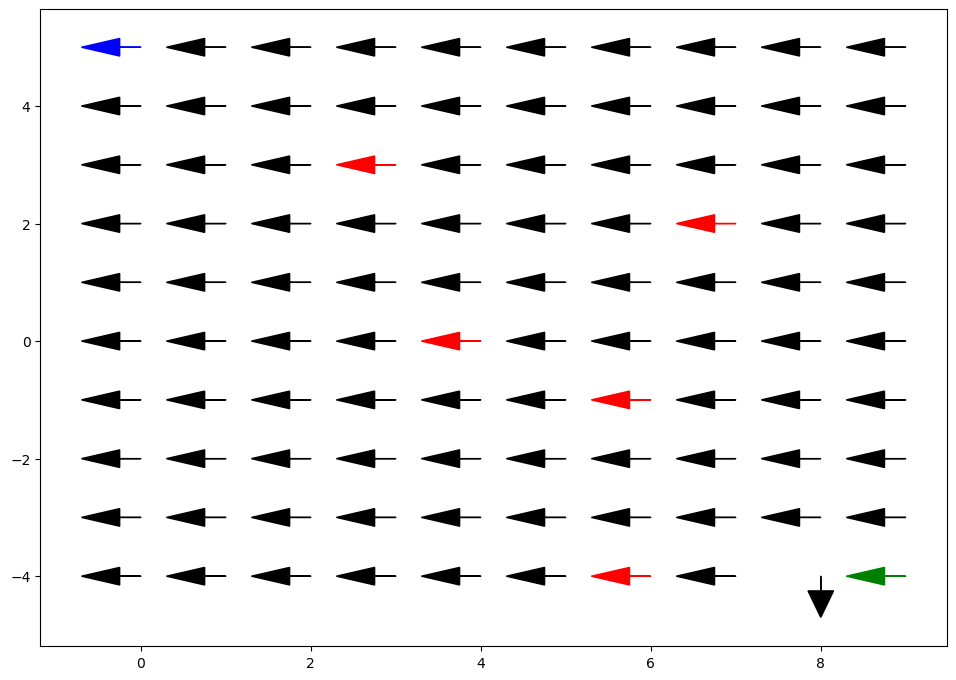

0.0001 0.8


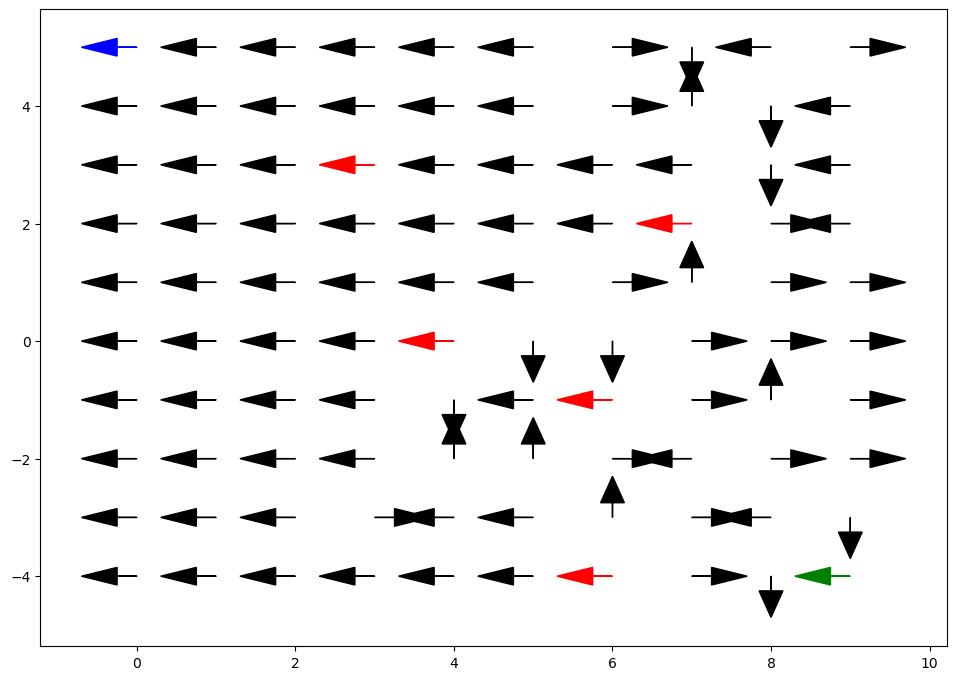

0.0001 0.7


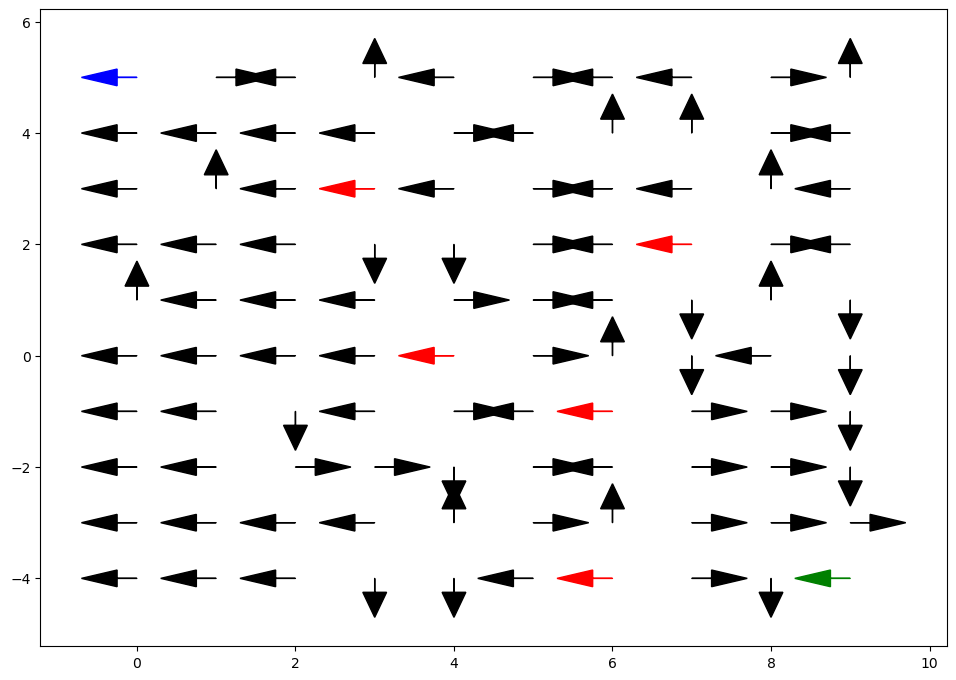

0.0001 0.5


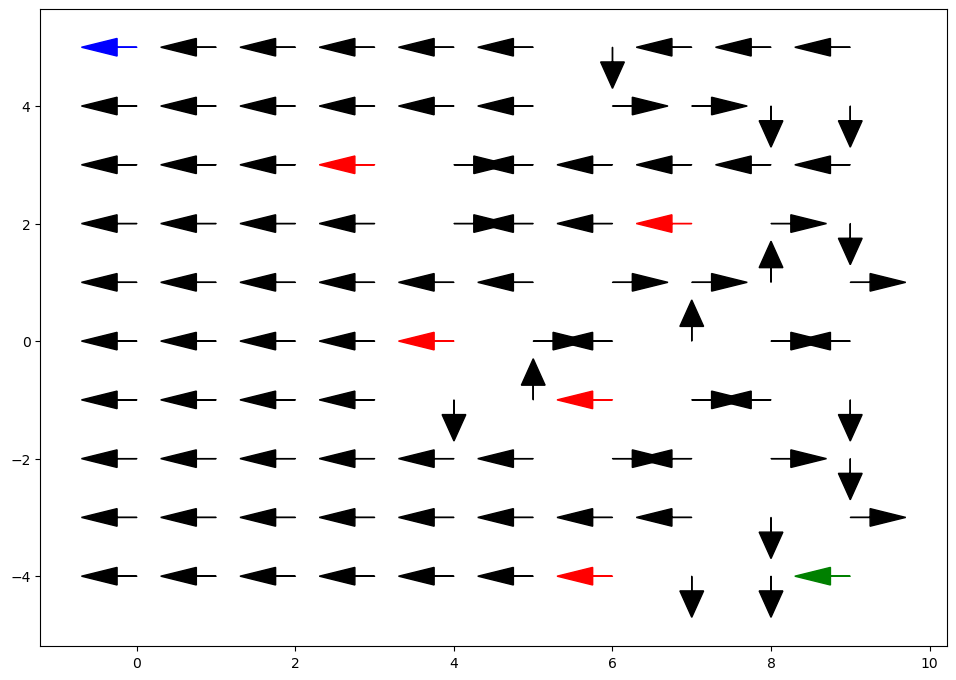

0.0001 0.4


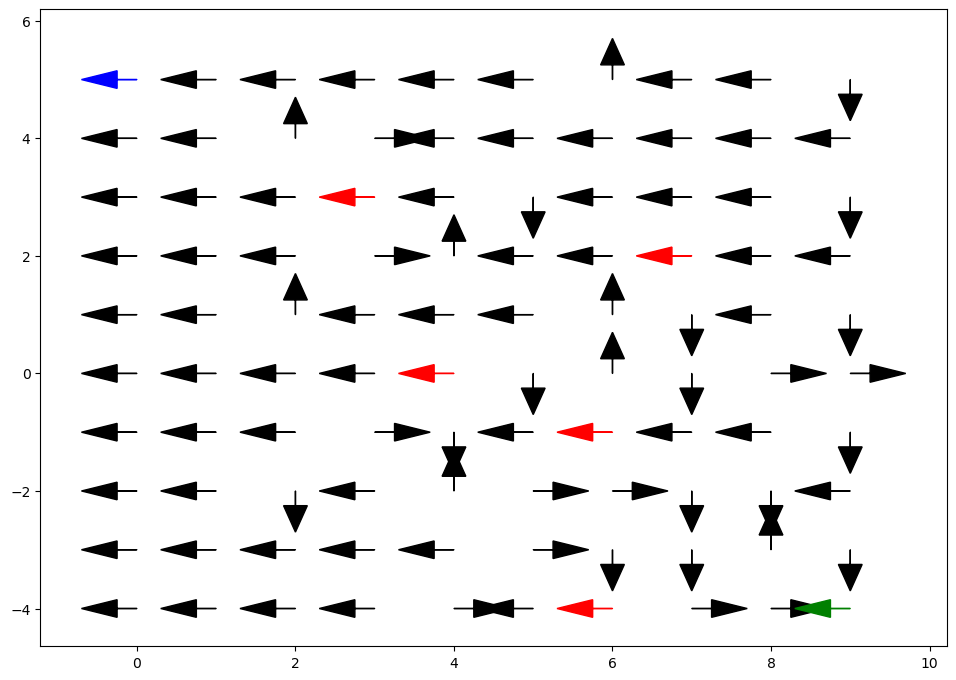

0.0001 0.1


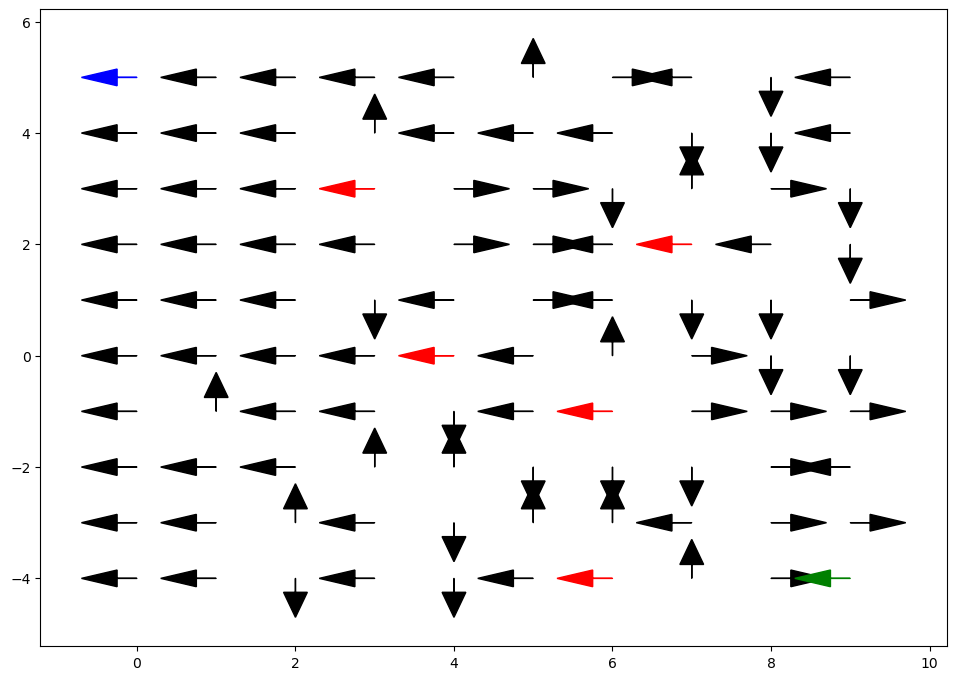

0.0001 0.01


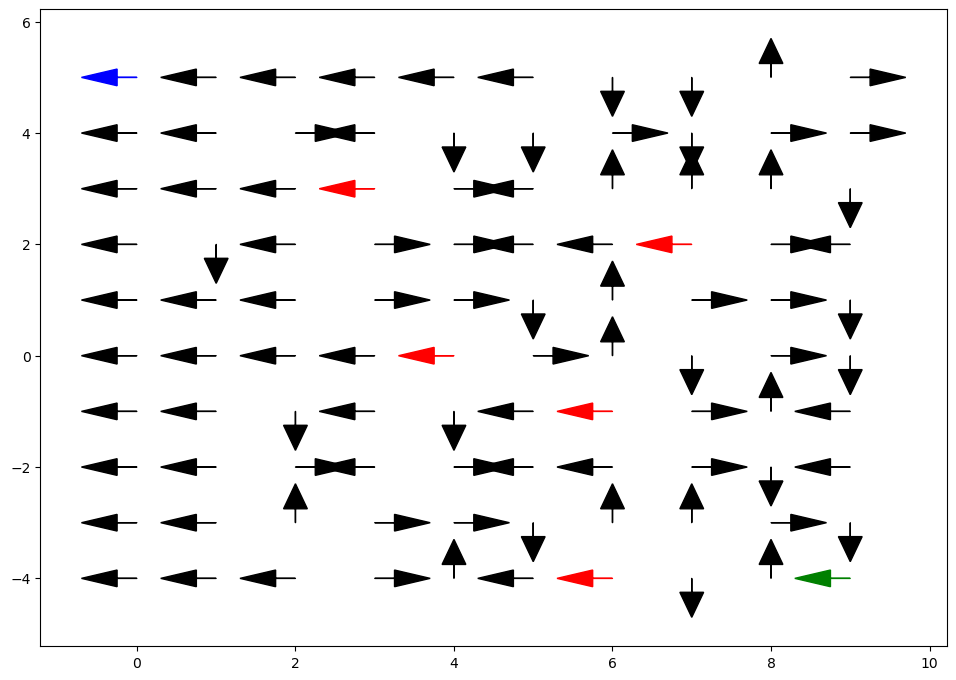

0.0001 0.001


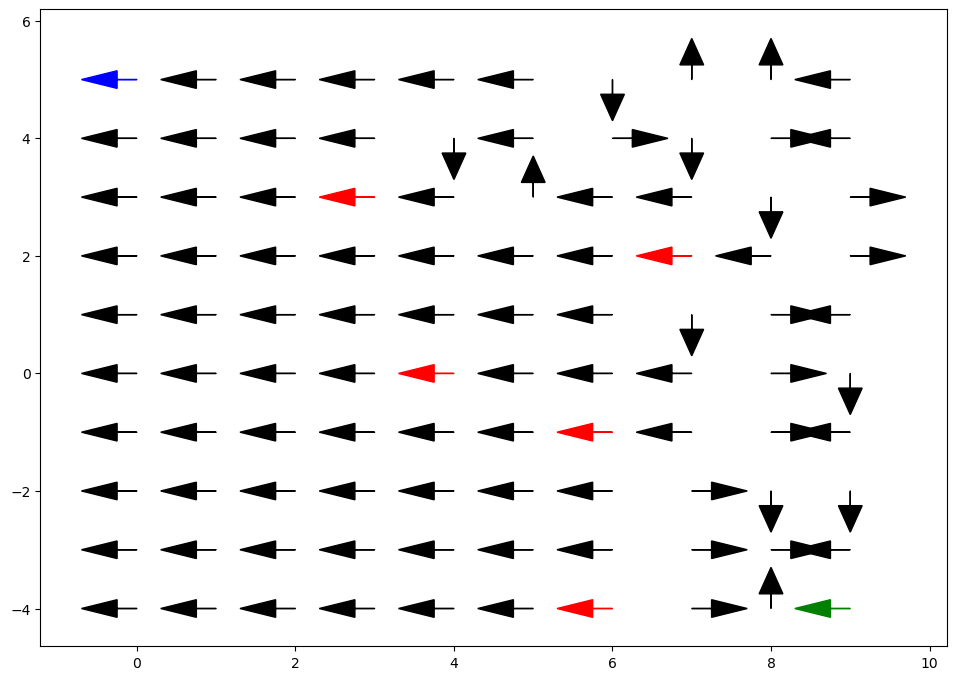

0.0001 0.0001


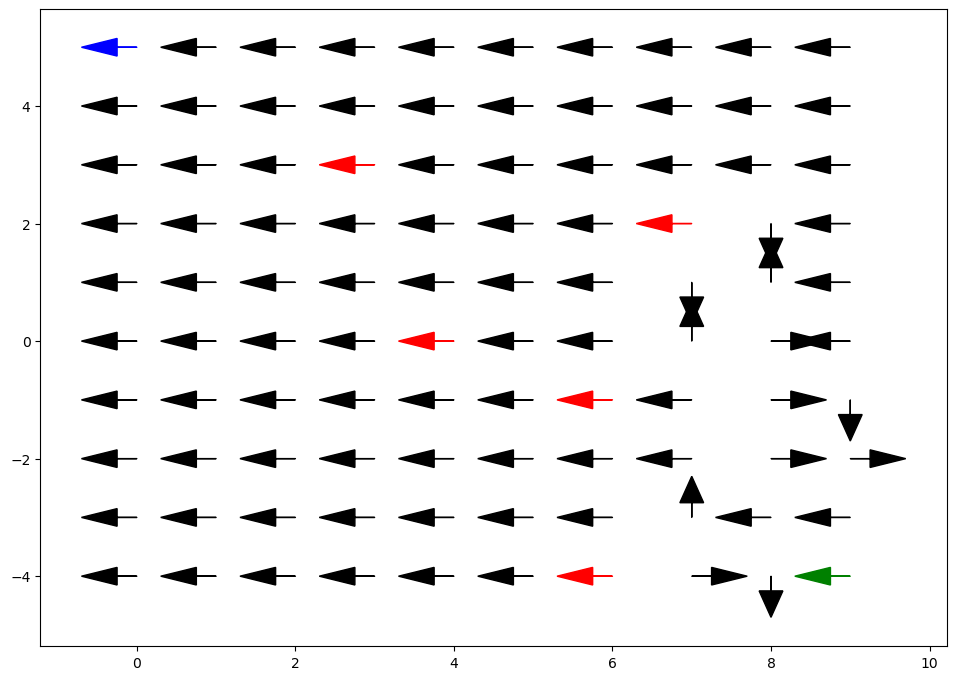

In [22]:
for e, i, policy in policies:
    print(e, i)
    visualize_policy(policy, 10, random_map)

<AxesSubplot:>

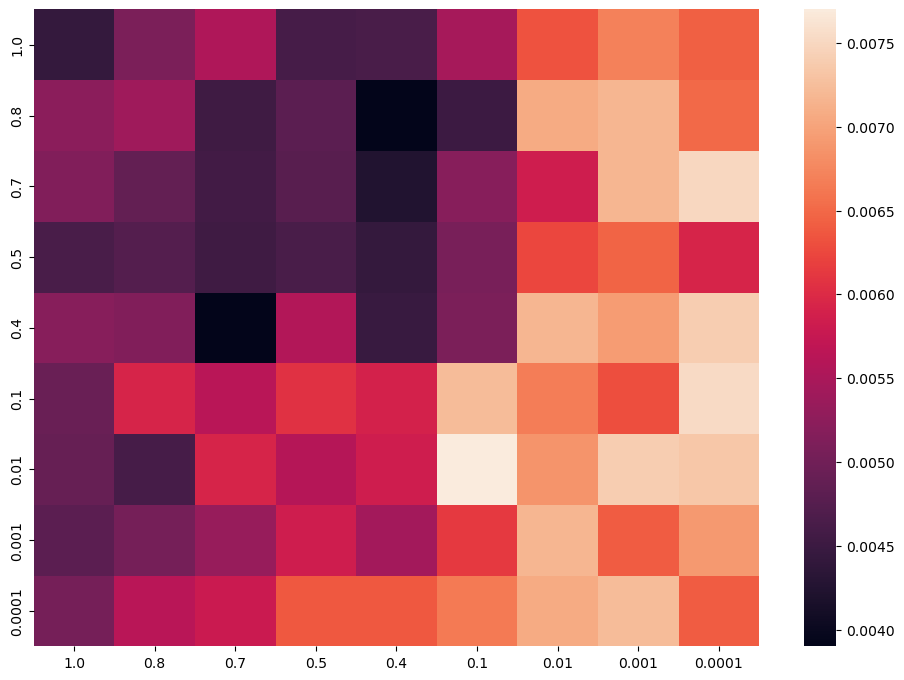

In [23]:
rewards_df = pd.DataFrame(rewards.T, index=alphas, columns=epsilons)
sns.heatmap(rewards_df)

<AxesSubplot:>

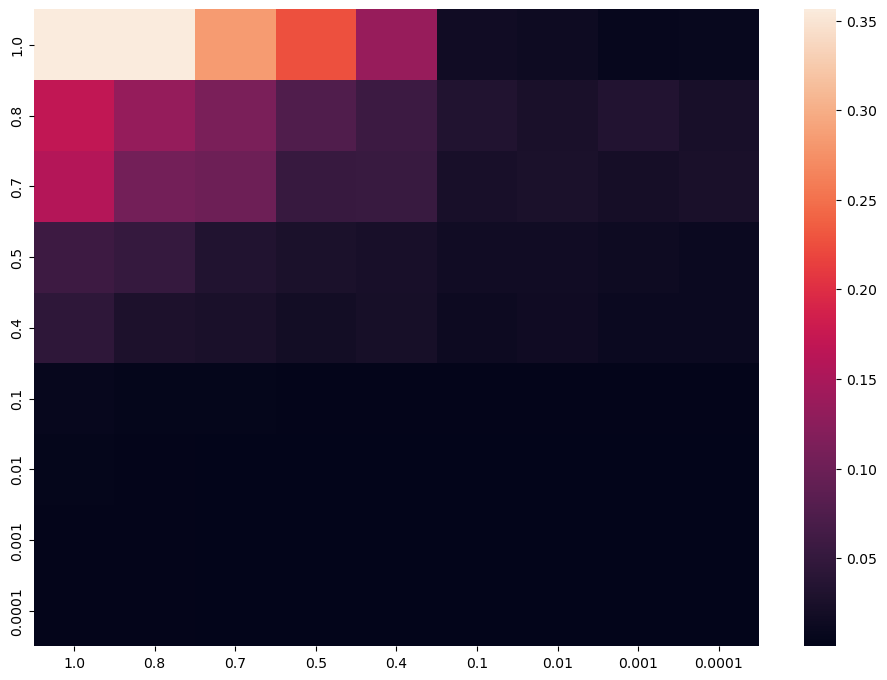

In [24]:
errors_df = pd.DataFrame(errors.T, index=alphas, columns=epsilons)
sns.heatmap(errors_df)

<AxesSubplot:>

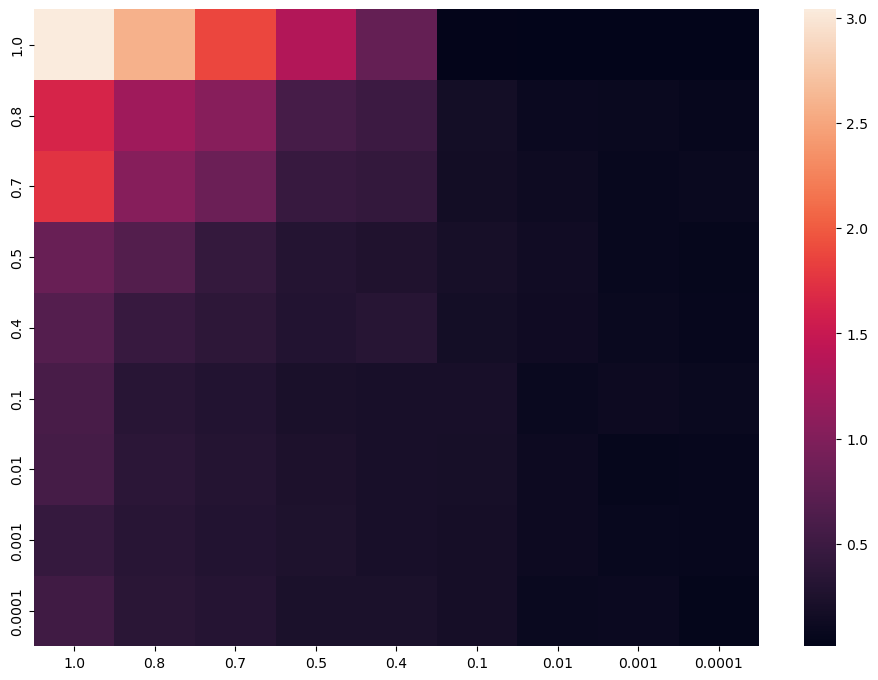

In [25]:
mean_values_df = pd.DataFrame(mean_values.T, index=alphas, columns=epsilons)
sns.heatmap(mean_values_df)

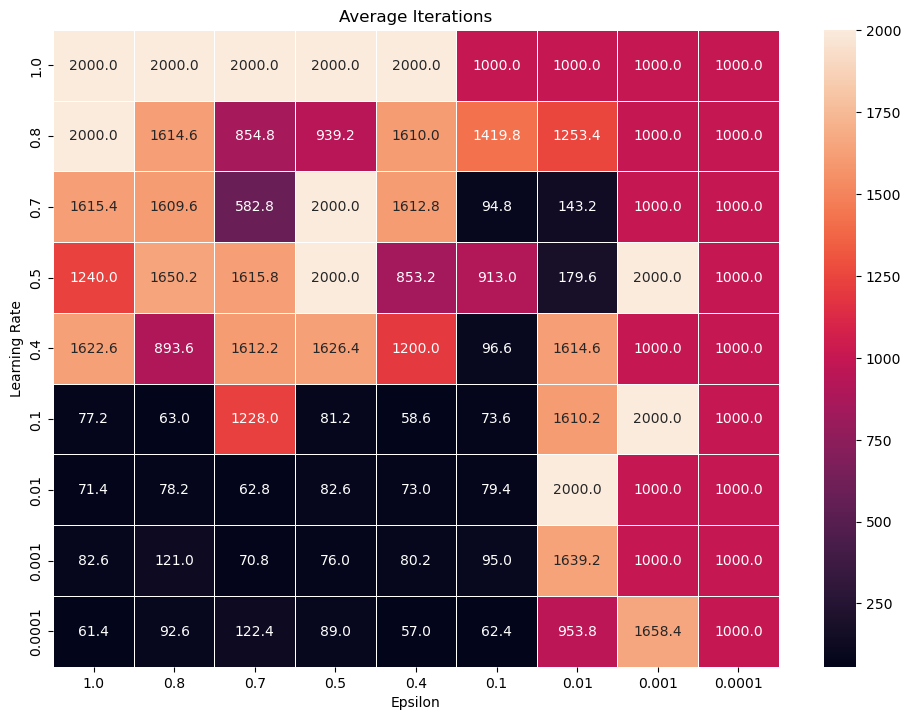

In [26]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
mean_iterations_df = pd.DataFrame(number_iterations.T, index=alphas, columns=epsilons)

sns.heatmap(mean_iterations_df, linewidth=.4, annot=True, fmt='.1f').set(title='Average Iterations', xlabel='Epsilon', ylabel='Learning Rate')
plt.savefig('learningrateepsilon.png', format='png')